## 0. Preparativos (no correr)

### Primero importo la red

In [1]:
import pandas as pd

# Cargar el archivo Excel
df_0 = pd.read_excel("red.xlsx", sheet_name="Interacciones")  # Ajusta el nombre de la hoja

In [2]:
import pandas as pd
from pygbif import species
import time
import json
from pathlib import Path
from tqdm import tqdm

# Cargar y filtrar datos iniciales
df_0 = pd.read_excel("red.xlsx", sheet_name="Interacciones")
columnas_deseadas = [
    "Taxón 1", "Origen taxón 1", "Taxón 2", "Origen taxón 2", 
    "Título de interacción", "Reportada en el distrito"
]
df = df_0[columnas_deseadas].drop_duplicates(
    subset=["Taxón 1", "Taxón 2", "Título de interacción"], 
    keep='first'
).copy()

# Cargar caché existente o crear uno nuevo
cache_file = Path("reinos_cache.json")
if cache_file.exists():
    with open(cache_file, 'r') as f:
        reinos_cache = json.load(f)
else:
    reinos_cache = {}

# Función mejorada con manejo de errores detallado
def obtener_reino(taxon):
    if not taxon or pd.isna(taxon):
        return None
        
    if taxon in reinos_cache:
        return reinos_cache[taxon]
        
    try:
        # Primera búsqueda estricta
        result = species.name_backbone(name=taxon, rank='species')
        if 'kingdom' in result:
            reinos_cache[taxon] = result['kingdom']
            return result['kingdom']
            
        # Búsqueda menos estricta si no se encontró
        result = species.name_backbone(name=taxon, strict=False)
        if 'kingdom' in result:
            reinos_cache[taxon] = result['kingdom']
            return result['kingdom']
            
        reinos_cache[taxon] = None
        print(f"\n⚠️ No se encontró reino para: {taxon}")
        return None
        
    except Exception as e:
        print(f"\n❌ Error con taxón '{taxon}': {str(e)}")
        reinos_cache[taxon] = None
        return None

# Procesar taxones únicos
taxones_unicos = list(set(df['Taxón 1'].tolist() + df['Taxón 2'].tolist()))
taxones_unicos = [t for t in taxones_unicos if t and pd.notna(t)]

print(f"\nConsultando GBIF para {len(taxones_unicos)} taxones únicos...")

# Consultar GBIF con barra de progreso
for taxon in tqdm(taxones_unicos):
    if taxon not in reinos_cache:
        obtener_reino(taxon)
        time.sleep(0.3)  # Respetar límites de la API

# Guardar caché actualizado
with open(cache_file, 'w') as f:
    json.dump(reinos_cache, f)

# Asignar reinos al DataFrame
df['Reino 1'] = df['Taxón 1'].map(reinos_cache)
df['Reino 2'] = df['Taxón 2'].map(reinos_cache)

# Estadísticas
exitosos = sum(1 for v in reinos_cache.values() if v is not None)
print(f"\nResultados:")
print(f"- Taxones consultados: {len(reinos_cache)}")
print(f"- Reinos identificados: {exitosos}")
print(f"- Sin identificar: {len(reinos_cache) - exitosos}")

# Mostrar preview
print("\nPrevisualización de datos:")
print(df[['Taxón 1', 'Reino 1', 'Taxón 2', 'Reino 2']].head())

# Guardar resultados
output_file = "red_con_reinos.xlsx"
df.to_excel(output_file, index=False)
print(f"\n✅ Datos guardados en: {output_file}")


Consultando GBIF para 2730 taxones únicos...


100%|█████████████████████████████████████████████████████████████████████████| 2730/2730 [00:00<00:00, 1457727.55it/s]


Resultados:
- Taxones consultados: 2730
- Reinos identificados: 2645
- Sin identificar: 85

Previsualización de datos:


           Taxón 1  Reino 1                 Taxón 2   Reino 2
0            Fungi    Fungi     Fragaria × ananassa   Plantae
1        Bryophyta  Plantae          Ilex kunthiana   Plantae
2        Bryophyta  Plantae     Viburnum triphyllum   Plantae
3  Marchantiophyta  Plantae                Viburnum   Plantae
4      Hexanauplia     None  Culex quinquefasciatus  Animalia

✅ Datos guardados en: red_con_reinos.xlsx


### Filtro la red y la guardo

In [3]:
# Filtrar solo las columnas deseadas
columnas_deseadas = [
    "Taxón 1", 
    "Origen taxón 1", 
    "Taxón 2", 
    "Origen taxón 2", 
    "Título de interacción", 
    "Reportada en el distrito"
]

df_00 = df_0[columnas_deseadas]

# Eliminar filas duplicadas, conservando la primera aparición (parte donde ocurre la interacción)
df = df_00.drop_duplicates(subset=["Taxón 1", "Taxón 2", "Título de interacción"], keep='first')

Guardo la red filtrada en un .xlsx nuevo

In [4]:
df.to_excel("red_filtrada.xlsx", index=False)

## 1. Construir redes

### Importar la red

In [5]:
import pandas as pd

# Cargar el archivo Excel
df = pd.read_excel("red_con_reinos.xlsx", sheet_name="Sheet1")  # Ajusta el nombre de la hoja

### crea red G y subredes G_r (solo interacciones reportadas en el distrito), G_o (interacciones que no tienen N/A en su origen), G_ro (ambas)

In [6]:
import networkx as nx
from collections import defaultdict
import pandas as pd

# Función para determinar el tipo de origen con manejo de NaN
def determinar_origen(origen1, origen2):
    # Manejar valores faltantes
    origen1 = origen1 if pd.notna(origen1) else "N/A"
    origen2 = origen2 if pd.notna(origen2) else "N/A"
    
    return f"{origen1}-{origen2}"

# Función para determinar el tipo de reino con manejo de NaN
def determinar_reino(reino1, reino2):
    # Manejar valores faltantes
    reino1 = reino1 if pd.notna(reino1) else "Reino_no_identificado"
    reino2 = reino2 if pd.notna(reino2) else "Reino_no_identificado"
    
    return f"{reino1}-{reino2}"

# Paso 1: Procesar datos y crear estructura mejorada
interacciones_detalladas = []
for _, row in df.iterrows():
    interaccion = {
        "Taxón 1": row["Taxón 1"],
        "Taxón 2": row["Taxón 2"],
        "Interacción": row["Título de interacción"],
        "Reportada": row["Reportada en el distrito"],
        "Origen": determinar_origen(row["Origen taxón 1"], row["Origen taxón 2"]),
        "Reino": determinar_reino(row.get("Reino 1", None), row.get("Reino 2", None))
    }
    interacciones_detalladas.append(interaccion)

# Paso 2: Consolidar por pares de especies
pares_consolidados = defaultdict(lambda: {
    "Interacciones": [],
    "Origen": None,
    "Reportada":None,
    "Reino": None
})

for item in interacciones_detalladas:
    par = (item["Taxón 1"], item["Taxón 2"])
    pares_consolidados[par]["Interacciones"].append(item["Interacción"])
    pares_consolidados[par]["Origen"] = item["Origen"]
    pares_consolidados[par]["Reino"] = item["Reino"]
    pares_consolidados[par]["Reportada"] = item["Reportada"]

# Crear los diferentes grafos
G = nx.DiGraph()  # Grafo completo (todas las interacciones)
G_r = nx.DiGraph()  # Solo interacciones reportadas (SI)
G_o = nx.DiGraph()  # Solo interacciones con origen conocido (sin N/A)
G_ro = nx.DiGraph()  # Interacciones reportadas Y con origen conocido

for par, datos in pares_consolidados.items():
    # Atributos comunes
    edge_attrs = {
        "interacciones": ", ".join(datos["Interacciones"]),
        "origen": datos["Origen"],
        "reino": datos["Reino"]
    }
    
    # 1. Grafo completo (G)
    G.add_edge(par[0], par[1], **edge_attrs)
    
    # 2. Grafo reportado (G_r)
    if datos["Reportada"] == "SI":
        G_r.add_edge(par[0], par[1], **edge_attrs)
    
    # 3. Grafo con origen conocido (G_o)
    if "N/A" not in datos["Origen"]:
        G_o.add_edge(par[0], par[1], **edge_attrs)
    
    # 4. Grafo reportado y origen conocido (G_ro)
    if datos["Reportada"] == "SI" and "N/A" not in datos["Origen"]:
        G_ro.add_edge(par[0], par[1], **edge_attrs)

# Función para imprimir análisis de un grafo
def analizar_grafo(grafo, nombre):
    print(f"\n{nombre}:")
    print(f"Nodos: {grafo.number_of_nodes()}")
    print(f"Aristas: {grafo.number_of_edges()}")
    
    if grafo.number_of_edges() > 0:
        print("\nDistribución de orígenes:")
        origen_counts = defaultdict(int)
        for _, _, data in grafo.edges(data=True):
            origen_counts[data['origen']] += 1
        for origen, count in sorted(origen_counts.items()):
            print(f"{origen}: {count} ({count/grafo.number_of_edges():.1%})")
        
        print("\nDistribución de reinos:")
        reino_counts = defaultdict(int)
        for _, _, data in grafo.edges(data=True):
            reino_counts[data['reino']] += 1
        for reino, count in sorted(reino_counts.items()):
            print(f"{reino}: {count} ({count/grafo.number_of_edges():.1%})")

# Análisis solo del grafo completo (G)
print("\n" + "="*50)
print("ANÁLISIS DE LA RED COMPLETA (G)")
print("="*50)
analizar_grafo(G, "Grafo completo")

# Resumen de los otros grafos
#print("\n" + "="*50)
#print("RESUMEN DE SUBREDES")
#print("="*50)
#print(f"\nGrafo reportado (G_r): {G_r.number_of_nodes()} nodos, {G_r.number_of_edges()} aristas")
#print(f"Grafo origen conocido (G_o): {G_o.number_of_nodes()} nodos, {G_o.number_of_edges()} aristas")
#print(f"Grafo reportado y origen conocido (G_ro): {G_ro.number_of_nodes()} nodos, {G_ro.number_of_edges()} aristas")



ANÁLISIS DE LA RED COMPLETA (G)

Grafo completo:
Nodos: 2730
Aristas: 6665

Distribución de orígenes:
N/A-N/A: 106 (1.6%)
N/A-Nativa: 406 (6.1%)
N/A-No nativa: 329 (4.9%)
Nativa-N/A: 389 (5.8%)
Nativa-Nativa: 1980 (29.7%)
Nativa-No nativa: 1346 (20.2%)
No nativa-N/A: 79 (1.2%)
No nativa-Nativa: 490 (7.4%)
No nativa-No nativa: 1540 (23.1%)

Distribución de reinos:
Animalia-Animalia: 497 (7.5%)
Animalia-Bacteria: 31 (0.5%)
Animalia-Chromista: 1 (0.0%)
Animalia-Fungi: 10 (0.2%)
Animalia-Plantae: 4885 (73.3%)
Animalia-Protozoa: 4 (0.1%)
Animalia-Reino_no_identificado: 68 (1.0%)
Bacteria-Animalia: 15 (0.2%)
Bacteria-Fungi: 5 (0.1%)
Bacteria-Plantae: 57 (0.9%)
Chromista-Animalia: 20 (0.3%)
Chromista-Plantae: 31 (0.5%)
Fungi-Animalia: 9 (0.1%)
Fungi-Fungi: 2 (0.0%)
Fungi-Plantae: 538 (8.1%)
Fungi-Reino_no_identificado: 45 (0.7%)
Plantae-Animalia: 1 (0.0%)
Plantae-Fungi: 6 (0.1%)
Plantae-Plantae: 332 (5.0%)
Plantae-Reino_no_identificado: 5 (0.1%)
Protozoa-Animalia: 5 (0.1%)
Protozoa-Plantae: 

In [7]:
#analizar_grafo(G_r, "Grafo reportado (G_r)")
analizar_grafo(G_o, "Grafo origen conocido (G_o)")
#analizar_grafo(G_ro, "Grafo reportado y origen conocido (G_ro)")


Grafo origen conocido (G_o):
Nodos: 1990
Aristas: 5356

Distribución de orígenes:
Nativa-Nativa: 1980 (37.0%)
Nativa-No nativa: 1346 (25.1%)
No nativa-Nativa: 490 (9.1%)
No nativa-No nativa: 1540 (28.8%)

Distribución de reinos:
Animalia-Animalia: 241 (4.5%)
Animalia-Bacteria: 7 (0.1%)
Animalia-Plantae: 4595 (85.8%)
Animalia-Reino_no_identificado: 23 (0.4%)
Bacteria-Plantae: 20 (0.4%)
Chromista-Animalia: 1 (0.0%)
Chromista-Plantae: 24 (0.4%)
Fungi-Animalia: 6 (0.1%)
Fungi-Plantae: 96 (1.8%)
Fungi-Reino_no_identificado: 3 (0.1%)
Plantae-Animalia: 1 (0.0%)
Plantae-Plantae: 303 (5.7%)
Reino_no_identificado-Fungi: 11 (0.2%)
Reino_no_identificado-Plantae: 25 (0.5%)


### Metricas iniciales

In [8]:
import pandas as pd
import networkx as nx

# Diccionario de grafos dirigidos a analizar
grafos = {
    "G (Completo)": G,
    #"G_r (Reportadas)": G_r,
    "G_o (Origen conocido)": G_o
    #"G_ro (Report+Origen)": G_ro
}

def calcular_metricas_digrafo(grafo):
    metricas = {}
    
    # Métricas básicas
    metricas["Nodos"] = grafo.number_of_nodes()
    metricas["Aristas"] = grafo.number_of_edges()
    metricas["Interacciones"] = sum(len(data['interacciones'].split(', ')) for _, _, data in grafo.edges(data=True))
    
    # Conectividad y componentes
    metricas["Es fuertemente conexo"] = nx.is_strongly_connected(grafo)
    metricas["Es débilmente conexo"] = nx.is_weakly_connected(grafo)
    
    # Componente gigante (usando componentes débilmente conexas)
    componentes = list(nx.weakly_connected_components(grafo))
    componente_gigante = grafo.subgraph(max(componentes, key=len))
    tamaño_gigante = len(componente_gigante)
    metricas["Tamaño componente gigante"] = f"{tamaño_gigante} ({tamaño_gigante/metricas['Nodos']:.1%})"
    
    # Métricas del componente gigante
    if tamaño_gigante > 1:
        try:
            # Convertir a no dirigido para cálculo de distancias
            G_gigante_no_dirigido = componente_gigante.to_undirected()
            metricas["Distancia promedio (gigante)"] = nx.average_shortest_path_length(G_gigante_no_dirigido)
            metricas["Diámetro (gigante)"] = nx.diameter(G_gigante_no_dirigido)
        except Exception as e:
            metricas["Distancia promedio (gigante)"] = f"Error: {str(e)}"
            metricas["Diámetro (gigante)"] = f"Error: {str(e)}"
    else:
        metricas["Distancia promedio (gigante)"] = "N/A (componente trivial)"
        metricas["Diámetro (gigante)"] = "N/A (componente trivial)"
    
    # Grados
    if metricas["Nodos"] > 0:
        grados_entrada = [d for n, d in grafo.in_degree()]
        grados_salida = [d for n, d in grafo.out_degree()]
        metricas["Grado promedio"] = sum(grados_entrada)/len(grados_entrada)
        metricas["Grado entrada máximo"] = max(grados_entrada)
        metricas["Grado salida máximo"] = max(grados_salida)
    
    # Densidad
    metricas["Densidad"] = nx.density(grafo)
    
    return metricas

# Recolectar métricas para todos los grafos
datos = {nombre: calcular_metricas_digrafo(grafo) for nombre, grafo in grafos.items()}

# Convertir a DataFrame y transponer correctamente
df_metricas = pd.DataFrame.from_dict(datos, orient='index').T  # Transposición aquí

# Orden personalizado de filas (métricas)
orden_filas = [
    'Nodos', 'Aristas', 'Interacciones',
    'Es fuertemente conexo', 'Es débilmente conexo',
    'Tamaño componente gigante',
    'Distancia promedio (gigante)', 'Diámetro (gigante)',
    'Grado promedio',
    'Grado entrada máximo', 'Grado salida máximo',
    'Densidad'
]

# Reindexar para ordenar las filas
df_metricas = df_metricas.reindex(orden_filas)

# Formatear valores
def formatear_valor(v):
    if isinstance(v, bool):
        return "Sí" if v else "No"
    elif isinstance(v, float):
        return f"{v:.3f}"
    return v

df_metricas = df_metricas.map(formatear_valor)

# Mostrar resultados
print("\n" + "="*80)
print("MÉTRICAS COMPARATIVAS DE REDES DIRIGIDAS")
print("="*80)
print(df_metricas.to_string())


MÉTRICAS COMPARATIVAS DE REDES DIRIGIDAS
                              G (Completo) G_o (Origen conocido)
Nodos                                 2730                  1990
Aristas                               6665                  5356
Interacciones                         7316                  5989
Es fuertemente conexo                   No                    No
Es débilmente conexo                    No                    No
Tamaño componente gigante     2671 (97.8%)          1943 (97.6%)
Distancia promedio (gigante)         4.221                 3.849
Diámetro (gigante)                      11                    10
Grado promedio                       2.441                 2.691
Grado entrada máximo                    88                    56
Grado salida máximo                    463                   458
Densidad                             0.001                 0.001


## 2. Anidamiento

### Primer filtro de cada subgrafo en red mutualista y red no mutualista

In [9]:
# Definir interacciones mutualistas (ajusta según tu clasificación)
MUTUALISMO = {'VISITA FLORAL', 'DISPERSIÓN', 'MUTUALISMO'}
PARASITISMO = {'PARASITISMO'}

def filtrar_redes_mutualistas(G):
    def _filtrar(grafo):
        grafo_m = grafo.__class__()  # Mismo tipo que el grafo original (DiGraph/Graph)
        grafo_p = grafo.__class__()
        
        for u, v, data in grafo.edges(data=True):
            interacciones = set(data['interacciones'].split(", "))
            # Si TODAS las interacciones son mutualistas -> grafo_m
            if interacciones.issubset(MUTUALISMO):
                grafo_m.add_edge(u, v, **data)
            elif interacciones.issubset(PARASITISMO):
                grafo_p.add_edge(u, v, **data)
        
        return grafo_m, grafo_p

    # Aplicar a todas las redes
    G_m, G_p = _filtrar(G)
    
    return {
        'G_m': G_m, 'G_p': G_p
        #'G_r_m': G_r_m, 'G_r_n': G_r_n,
        #'G_o_m': G_o_m, 'G_o_n': G_o_n,
        #'G_ro_m': G_ro_m, 'G_ro_n': G_ro_n
    }

# Uso
redes_filtradas = filtrar_redes_mutualistas(G)

# Acceder a las redes ej: redes_filtradas['G_m'], redes_filtradas['G_r_n'], etc.

### Métricas iniciales de cada subgrafo

In [6]:
import networkx as nx
import pandas as pd

def calcular_metricas(redes_filtradas):
    metricas = []
    for nombre, grafo in redes_filtradas.items():
        if grafo.number_of_nodes() == 0:
            continue  # Saltar grafos vacíos
        
        # Métricas básicas
        n_nodos = grafo.number_of_nodes()
        n_aristas = grafo.number_of_edges()
        n_componentes = nx.number_weakly_connected_components(grafo) if grafo.is_directed() else nx.number_connected_components(grafo)
        
        # Componente gigante
        componente_gigante = max(
            nx.weakly_connected_components(grafo) if grafo.is_directed() else nx.connected_components(grafo),
            key=len
        )
        tamano_gigante = len(componente_gigante)
        porcentaje_gigante = (tamano_gigante / n_nodos) * 100
        
        
        metricas.append({
            'Subgrafo': nombre,
            'Nodos': n_nodos,
            'Aristas': n_aristas,
            'Componentes': n_componentes,
            'Tamaño componente gigante': f"{tamano_gigante} ({porcentaje_gigante:.1f}%)"
        })
    
    return pd.DataFrame(metricas).set_index('Subgrafo')

# Uso
redes_filtradas = filtrar_redes_mutualistas(G)  # Usando la función anterior
tabla_metricas = calcular_metricas(redes_filtradas)
print(tabla_metricas)

          Nodos  Aristas  Componentes Tamaño componente gigante
Subgrafo                                                       
G_m        1117     2580           25              1055 (94.4%)
G_p         324      285           55               114 (35.2%)


### Ahora división en subsubgrafos por reinos de cada subgrafo mutualista

In [7]:
def crear_subsubredes_para_todos_pares(grafos_de_entrada):
    """
    Crea subredes por pares de reinos conservando toda la nomenclatura original
    
    Args:
        grafos_de_entrada (dict): Diccionario de grafos {nombre: grafo}
    """
    # Extraer todos los pares de reinos únicos de los datos
    pares_reinos = set()
    for nombre, grafo in grafos_de_entrada.items():
        for u, v, data in grafo.edges(data=True):
            reino_u, reino_v = data['reino'].split("-")
            par = tuple(sorted((reino_u, reino_v)))
            pares_reinos.add(par)
    
    # Crear subsubredes para cada par (conservando atributos)
    subsubredes = {}
    for nombre, grafo in grafos_de_entrada.items():
        
        for reino1, reino2 in pares_reinos:
            # Construir nombre completo de la subred
            key = f"{nombre}_{reino1[:2].lower()}{reino2[:2].lower()}"
            
            # Filtrar aristas para este par de reinos
            edges_with_data = [
                (u, v, data) for u, v, data in grafo.edges(data=True)
                if {data['reino'].split("-")[0], data['reino'].split("-")[1]} == {reino1, reino2}
            ]
            
            # Crear subgrafo conservando atributos
            subgrafo = grafo.__class__()
            subgrafo.add_edges_from(edges_with_data)
            subsubredes[key] = subgrafo
    
    return subsubredes

# 1. Filtrar solo las redes mutualistas
#grafos_mutualistas = {k: v for k, v in redes_filtradas.items() if k.endswith('_m')}
# 2. Crear subredes por pares de reinos
subsubredes_mutualistas = crear_subsubredes_para_todos_pares(redes_filtradas)

# Función para generar la tabla (similar a la anterior, pero optimizada)
def generar_tabla_subsubredes(subsubredes):
    datos = []
    for nombre, grafo in subsubredes.items():
        if grafo.number_of_nodes() == 0:
            continue  # Ignorar subredes vacías
        
        n_nodos = grafo.number_of_nodes()
        n_aristas = grafo.number_of_edges()
        es_dirigido = grafo.is_directed()
        
        # Componentes conexas
        componentes = list(nx.weakly_connected_components(grafo)) if es_dirigido else list(nx.connected_components(grafo))
        n_componentes = len(componentes)
        tamano_gigante = len(max(componentes, key=len)) if componentes else 0
        porcentaje_gigante = (tamano_gigante / n_nodos * 100) if n_nodos > 0 else 0
        
        
        datos.append({
            'Subsubred': nombre,
            'Nodos': n_nodos,
            'Aristas': n_aristas,
            'Componentes': n_componentes,
            'Tamaño componente gigante': f"{tamano_gigante} ({porcentaje_gigante:.1f}%)"
        })
    
    return pd.DataFrame(datos).set_index('Subsubred')

# Generar tablas comparativas
print("=== Subredes Mutualistas ===")
tabla_completa = generar_tabla_subsubredes(subsubredes_mutualistas)
print(tabla_completa)

=== Subredes Mutualistas ===
           Nodos  Aristas  Componentes Tamaño componente gigante
Subsubred                                                       
G_m_rere       2        1            1                2 (100.0%)
G_m_bare       3        2            1                3 (100.0%)
G_m_anre      40       28           12                12 (30.0%)
G_m_plre      41       35           10                 9 (22.0%)
G_m_anch       2        1            1                2 (100.0%)
G_m_anan       6        3            3                 2 (33.3%)
G_m_bapl      25       26            5                15 (60.0%)
G_m_fupl      81      119            8                61 (75.3%)
G_m_anpl     953     2323           11               930 (97.6%)
G_m_anpr       5        4            1                5 (100.0%)
G_m_plpl       2        1            1                2 (100.0%)
G_m_anba      29       31            4                15 (51.7%)
G_m_anfu       6        5            1                6 (100.

### Gráfico de interacciones con isoclina de anidamiento (hay que entenderla)

NODF multiplica cada par de filas/columnas de la matriz de adyacencia para encontrar aristas comunes, luego divide sobre el grado de la fila/columna con el grado mínimo entre ambas, si el resultado es 1 signfica que una está completamente contenida en la otra, si es 0 no tienen aristas comunes y valores intermedios nos dan el espéctro entre ambas posibilidades. Luego de hacer esto para todos los pares de columnas y filas se promedian y se multiplica por 100% y se obtiene el valor de anidamiento NODF para la matríz de adayacencia. 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse import coo_matrix

def get_incidence_matrix(subgrafo):
    """Función generalizada para obtener matriz de incidencia para cualquier par de reinos"""
    # Determinar los dos reinos involucrados
    reinos = set()
    for u, v, data in subgrafo.edges(data=True):
        reino_u, reino_v = data['reino'].split("-")
        reinos.update([reino_u, reino_v])
    
    if len(reinos) != 2:
        raise ValueError("El subgrafo debe contener exactamente dos reinos diferentes")
    
    reino1, reino2 = sorted(reinos)  # Orden alfabético para consistencia
    
    # Identificar nodos por reino
    grupo1 = set()
    grupo2 = set()
    
    for u, v, data in subgrafo.edges(data=True):
        reino_u, reino_v = data['reino'].split("-")
        
        if reino_u == reino1:
            grupo1.add(u)
        elif reino_u == reino2:
            grupo2.add(u)
            
        if reino_v == reino1:
            grupo1.add(v)
        elif reino_v == reino2:
            grupo2.add(v)
    
    grupo1 = list(grupo1)
    grupo2 = list(grupo2)
    
    # Construir matriz de incidencia
    grupo1_to_idx = {nodo: i for i, nodo in enumerate(grupo1)}
    grupo2_to_idx = {nodo: i for i, nodo in enumerate(grupo2)}
    
    rows = []
    cols = []
    for u, v, data in subgrafo.edges(data=True):
        reino_u, reino_v = data['reino'].split("-")
        
        if reino_u == reino1 and reino_v == reino2:
            rows.append(grupo1_to_idx[u])
            cols.append(grupo2_to_idx[v])
        elif reino_u == reino2 and reino_v == reino1:
            rows.append(grupo1_to_idx[v])
            cols.append(grupo2_to_idx[u])
    
    data = np.ones(len(rows))
    matriz = coo_matrix((data, (rows, cols)), shape=(len(grupo1), len(grupo2))).toarray()
    return matriz, grupo1, grupo2, reino1, reino2

def calculate_nodf(matrix):
    """Calcula el NODF (Nestedness based on Overlap and Decreasing Fill) manualmente"""
    matrix = (matrix > 0).astype(int)  # Asegurar que sea binaria
    m, n = matrix.shape
    
    # Calcular para filas (plantas)
    row_nodf = 0
    for i in range(m):
        for j in range(i+1, m):
            if np.sum(matrix[i]) == 0 or np.sum(matrix[j]) == 0:
                continue
            if np.sum(matrix[i] * matrix[j]) > 0:
                row_nodf += 100 * (np.sum(matrix[i] * matrix[j]) / min(np.sum(matrix[i]), np.sum(matrix[j])))
    
    # Calcular para columnas (animales)
    col_nodf = 0
    for i in range(n):
        for j in range(i+1, n):
            if np.sum(matrix[:, i]) == 0 or np.sum(matrix[:, j]) == 0:
                continue
            if np.sum(matrix[:, i] * matrix[:, j]) > 0:
                col_nodf += 100 * (np.sum(matrix[:, i] * matrix[:, j]) / min(np.sum(matrix[:, i]), np.sum(matrix[:, j])))
    
    # Normalizar
    total_pairs = (m*(m-1)/2) + (n*(n-1)/2)
    nodf = (row_nodf + col_nodf) / total_pairs if total_pairs > 0 else 0
    return nodf

def plot_nestedness(matriz, grupo1, grupo2, reino1, reino2):
    """Grafica el anidamiento en escala lineal con isoclina basada en NODF"""
    fig, ax = plt.subplots(figsize=(8, 5))

    # Configuración del título
    
    
    # Ordenar matriz por grados
    row_sums = matriz.sum(axis=1)
    row_order = np.argsort(-row_sums)
    col_sums = matriz.sum(axis=0)
    col_order = np.argsort(-col_sums)
    matriz_sorted = matriz[row_order][:, col_order]
    m, n = matriz_sorted.shape

    #ax.set_xscale('log')
    #ax.set_yscale('log')
    titulo=f" {m} {reino1} x {n} {reino2}"

    # Ajustar ticks para que empiecen en 1
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(m))
    ax.set_xticklabels(np.arange(1, n+1))  # Columnas: 1, 2, ..., n
    ax.set_yticklabels(np.arange(1, m+1))  # Filas: 1, 2, ..., m
    
    # Calcular NODF y parámetro alpha
    nodf = calculate_nodf(matriz_sorted)
    alpha = (nodf / 100)  # Mapeo empírico de NODF a alpha, NODF = 100 -> alpha =1, NODF = 0, alpha = 0
    
    # Heatmap
    cax = ax.matshow(matriz_sorted, cmap='Blues', aspect='auto')
    
    # Isoclina basada en NODF
    x = np.linspace(0, n, 100)
    y = m * (1 - (x/n)**alpha)
    #ax.plot(x, y, 'r--', linewidth=2, 
     #       label=f'Isoclina (α={alpha:.2f}, NODF={nodf:.1f})')
    ax.plot(x, y, 'r--', linewidth=2)
    
    # Configuración del gráfico
    #ax.set_xlabel(f'{n} Especies de {reino2}', fontsize=12)
    #ax.set_ylabel(f'{m} Especies de {reino1}', fontsize=12)
    ax.set_title(f"{titulo} | NODF={nodf:.1f}")
    #ax.legend()
    
    #plt.colorbar(cax, label='Interacción (1 = presente)')
    plt.tight_layout()
    plt.savefig(f'{titulo}.png')
    plt.show()

# Ejemplo de uso para diferentes subsubredes
def plot_nestedness_for_subred(subred_name, subsubredes):
    if subred_name not in subsubredes:
        print(f"La subred {subred_name} no existe. Subredes disponibles: {list(subsubredes.keys())}")
        return
    
    try:
        matriz, grupo1, grupo2, reino1, reino2 = get_incidence_matrix(subsubredes[subred_name])
        
        # Determinar tipo de interacción
        if subred_name.startswith('G_m_'):
            tipo_interaccion = "mutualistas"
        elif subred_name.startswith('G_p_'):
            tipo_interaccion = "parasitistas"
        else:
            tipo_interaccion = ""
        
        # Llamar a plot_nestedness con título personalizado
        plot_nestedness(
            matriz, grupo1, grupo2, reino1, reino2
            #titulo=f"Anidamiento en interacciones {tipo_interaccion} {reino1}-{reino2}"
            #titulo=f"{m} {reino1}X {n} {reino2}"
        )
    except ValueError as e:
        print(f"Error al procesar {subred_name}: {str(e)}")


Grafos con más de 20 nodos:

G_m_fupl      
G_m_bapl      
G_m_anba      
G_m_anpl

G_p_anan      (no es bipartirta)
G_p_anpr      
G_p_plpl     (no es bipartirta)
G_p_fupl     
G_p_bapl      
G_p_plpr

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse import coo_matrix

def get_incidence_matrix(subgrafo):
    """Función generalizada para obtener matriz de incidencia para cualquier par de reinos"""
    # Determinar los dos reinos involucrados
    reinos = set()
    for u, v, data in subgrafo.edges(data=True):
        reino_u, reino_v = data['reino'].split("-")
        reinos.update([reino_u, reino_v])
    
    if len(reinos) != 2:
        raise ValueError("El subgrafo debe contener exactamente dos reinos diferentes")
    
    reino1, reino2 = sorted(reinos)  # Orden alfabético para consistencia
    
    # Identificar nodos por reino
    grupo1 = set()
    grupo2 = set()
    
    for u, v, data in subgrafo.edges(data=True):
        reino_u, reino_v = data['reino'].split("-")
        
        if reino_u == reino1:
            grupo1.add(u)
        elif reino_u == reino2:
            grupo2.add(u)
            
        if reino_v == reino1:
            grupo1.add(v)
        elif reino_v == reino2:
            grupo2.add(v)
    
    grupo1 = list(grupo1)
    grupo2 = list(grupo2)
    
    # Construir matriz de incidencia
    grupo1_to_idx = {nodo: i for i, nodo in enumerate(grupo1)}
    grupo2_to_idx = {nodo: i for i, nodo in enumerate(grupo2)}
    
    rows = []
    cols = []
    for u, v, data in subgrafo.edges(data=True):
        reino_u, reino_v = data['reino'].split("-")
        
        if reino_u == reino1 and reino_v == reino2:
            rows.append(grupo1_to_idx[u])
            cols.append(grupo2_to_idx[v])
        elif reino_u == reino2 and reino_v == reino1:
            rows.append(grupo1_to_idx[v])
            cols.append(grupo2_to_idx[u])
    
    data = np.ones(len(rows))
    matriz = coo_matrix((data, (rows, cols)), shape=(len(grupo1), len(grupo2))).toarray()
    return matriz, grupo1, grupo2, reino1, reino2

def calculate_nodf(matrix):
    """Calcula el NODF (Nestedness based on Overlap and Decreasing Fill) manualmente"""
    matrix = (matrix > 0).astype(int)  # Asegurar que sea binaria
    m, n = matrix.shape
    
    # Calcular para filas (plantas)
    row_nodf = 0
    for i in range(m):
        for j in range(i+1, m):
            if np.sum(matrix[i]) == 0 or np.sum(matrix[j]) == 0:
                continue
            if np.sum(matrix[i] * matrix[j]) > 0:
                row_nodf += 100 * (np.sum(matrix[i] * matrix[j]) / min(np.sum(matrix[i]), np.sum(matrix[j])))
    
    # Calcular para columnas (animales)
    col_nodf = 0
    for i in range(n):
        for j in range(i+1, n):
            if np.sum(matrix[:, i]) == 0 or np.sum(matrix[:, j]) == 0:
                continue
            if np.sum(matrix[:, i] * matrix[:, j]) > 0:
                col_nodf += 100 * (np.sum(matrix[:, i] * matrix[:, j]) / min(np.sum(matrix[:, i]), np.sum(matrix[:, j])))
    
    # Normalizar
    total_pairs = (m*(m-1)/2) + (n*(n-1)/2)
    nodf = (row_nodf + col_nodf) / total_pairs if total_pairs > 0 else 0
    return nodf

def calculate_perfect_order_line(matrix):
    """
    Calcula los dos segmentos diagonales de la línea de perfect order según φ.
    Devuelve los puntos (x1, y1) y (x2, y2) que definen los segmentos.
    """
    m, n = matrix.shape
    phi = matrix.sum() / (m * n)  # Fill percentage
    print(phi)
    x1 = n * phi
    y1 = m * phi
    
    return x1, y1

from scipy.integrate import quad
from scipy.optimize import brentq

def find_alpha(matrix, x1, y1, tol=1e-6):
    """
    Encuentra alpha resolviendo las intersecciones curve(x)=line(x) y ajustando las áreas
    """
    m, n = matrix.shape
    
    def line(x):
        if x <= x1:
            return m - (m - y1)/x1 * x if x1 != 0 else m
        else:
            return y1 - y1/(n - x1) * (x - x1) if (n - x1) != 0 else 0
    
    def find_intersections(alpha):
        def curve(x):
            return m * (1 - (x/n)**alpha)
        
        # Encontrar x0 (primera intersección)
        def diff1(x):
            return curve(x) - line(x)
        
        try:
            x0 = brentq(diff1, 0.1, x1, xtol=tol)
        except:
            x0 = 0
            
        # Encontrar x2 (segunda intersección)
        def diff2(x):
            return curve(x) - line(x)
        
        try:
            x2 = brentq(diff2, x1, n-0.1, xtol=tol)
        except:
            x2 = n
            
        return x0, x2, curve

    def area_condition(alpha):
        x0, x2, curve = find_intersections(alpha)
        
        # Áreas corregidas según los nuevos límites
        a1_prime, _ = quad(lambda x: curve(x) - line(x), 0, x0)
        a2_prime, _ = quad(lambda x: line(x) - curve(x), x0, x2)
        a_double_prime, _ = quad(lambda x: curve(x) - line(x), x2, n)
        
        return (a1_prime + a2_prime) - a_double_prime
        
    def area_condition_prueba(alpha):
        x0, x2, curve = find_intersections(alpha)
        # Áreas corregidas según los nuevos límites
        a1_prime, _ = quad(lambda x: curve(x) - line(x), 0, x0)
        a2_prime, _ = quad(lambda x: line(x) - curve(x), x0, x2)
        a_double_prime, _ = quad(lambda x: curve(x) - line(x), x2, n)
        
        return (a1_prime + a2_prime) - a_double_prime, a1_prime, a2_prime, a_double_prime, x0, x2, curve(x0) - line(x0), curve(x2) - line(x2)

    # Solución numérica robusta
    try:
        alpha = brentq(area_condition, 0, 1, xtol=tol)
        print(area_condition_prueba(alpha))
        return alpha
    except:
        return 1.0  # Fallback


def plot_nestedness(matriz, grupo1, grupo2, reino1, reino2):
    """Grafica el anidamiento en escala lineal con isoclina basada en NODF"""
    fig, ax = plt.subplots(figsize=(8, 5))

    # Ordenar matriz por grados
    row_sums = matriz.sum(axis=1)
    row_order = np.argsort(-row_sums)
    col_sums = matriz.sum(axis=0)
    col_order = np.argsort(-col_sums)
    matriz_sorted = matriz[row_order][:, col_order]
    m, n = matriz_sorted.shape

    titulo=f" {m} {reino1} x {n} {reino2}"

    # Ajustar ticks para que empiecen en 1
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(m))
    ax.set_xticklabels(np.arange(1, n+1))  # Columnas: 1, 2, ..., n
    ax.set_yticklabels(np.arange(1, m+1))  # Filas: 1, 2, ..., m
    
    # Calcular NODF y temperatura
    nodf = calculate_nodf(matriz_sorted)
    x1, y1 = calculate_perfect_order_line(matriz_sorted)
    print(x1,y1)
    alpha = find_alpha(matriz_sorted, x1, y1)
    
    # Heatmap
    cax = ax.matshow(matriz_sorted, cmap='Blues', aspect='auto')
    
    # Isoclina basada en NODF
    x = np.linspace(0, n, 100)
    y = m * (1 - (x/n)**alpha)
    ax.plot(x, y, 'r--', linewidth=2)
    
    # Configuración del gráfico
    #ax.set_title(f"{titulo} | NODF={nodf:.1f} | Temperature={temp:.1f}°")
    ax.set_title(f"{titulo} | NODF={nodf:.1f} | Temperature={alpha}°")
    
    plt.tight_layout()
    plt.savefig(f'{titulo}.png')
    plt.show()

# Ejemplo de uso para diferentes subsubredes
def plot_nestedness_for_subred(subred_name, subsubredes):
    if subred_name not in subsubredes:
        print(f"La subred {subred_name} no existe. Subredes disponibles: {list(subsubredes.keys())}")
        return
    
    try:
        matriz, grupo1, grupo2, reino1, reino2 = get_incidence_matrix(subsubredes[subred_name])
        
        # Llamar a plot_nestedness con título personalizado
        plot_nestedness(matriz, grupo1, grupo2, reino1, reino2)
    except ValueError as e:
        print(f"Error al procesar {subred_name}: {str(e)}")

0.07777777777777778
2.3333333333333335 3.966666666666667
(-31.016425695931314, -51.49968619225889, -1.2371963969651408e-09, -20.483260497564775, 2.3333314275131865, 2.333403138272888, -2.5965913605929813e-06, -1.8336887563918935e-11)


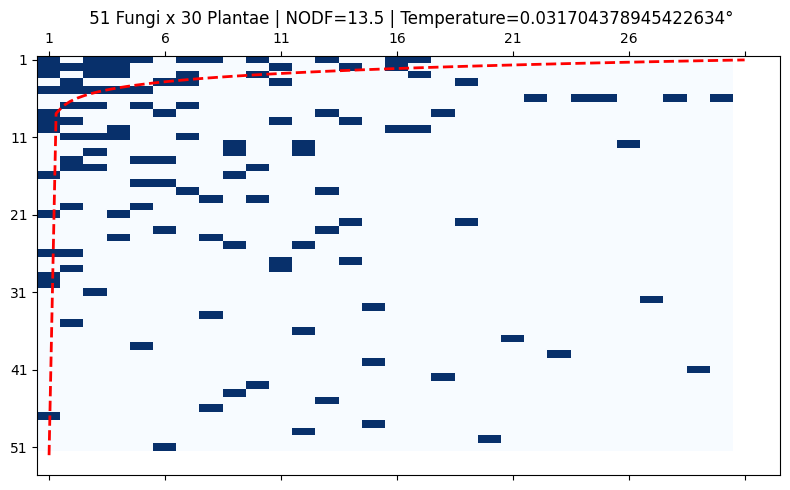

In [10]:
plot_nestedness_for_subred('G_m_fupl', subsubredes_mutualistas)  # Bacteria-Plantae

0.18055555555555555
1.625 2.888888888888889
(-5.871267205824816, -8.432520702813814, -2.412576985922893e-11, -2.5612534970131247, 1.624999126440864, 1.6250090918710103, -1.260442008543805e-06, -4.5347783306226574e-09)


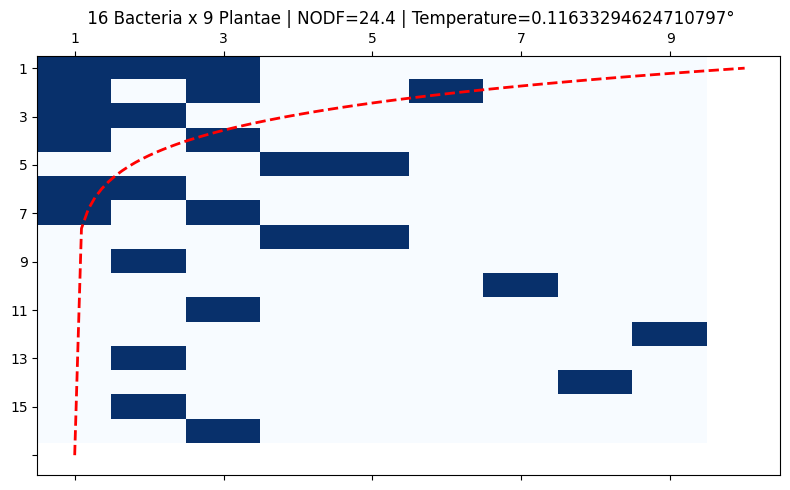

In [11]:
plot_nestedness_for_subred('G_m_bapl', subsubredes_mutualistas)  # Bacteria-Plantae

0.14903846153846154
2.3846153846153846 1.9375
(-7.512871034250232, -11.128109669461958, -3.449653670266572e-10, -3.615238635556691, 2.3846123746492878, 2.3846661570641006, -1.474376176702208e-13, 3.513986657210921e-08)


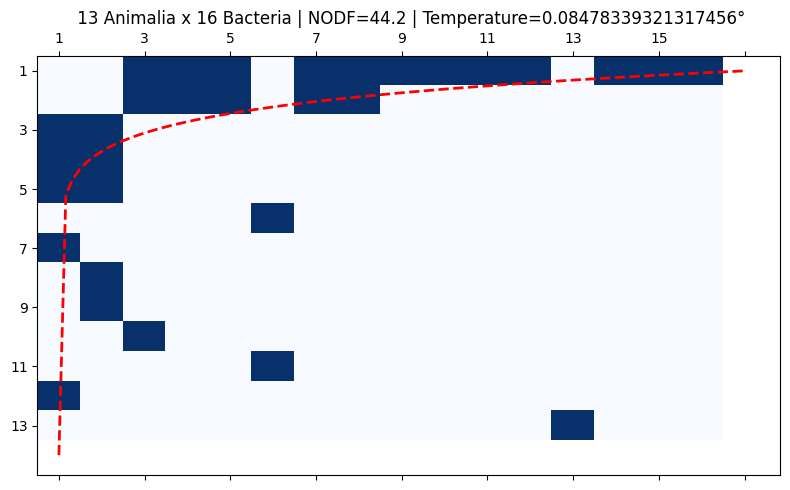

In [12]:
plot_nestedness_for_subred('G_m_anba', subsubredes_mutualistas)  # Animalia-bacteria

0.015716122048575875
11.912820512820513 3.0646437994722957
(-507.7937108682654, -1134.5543869424591, -4.0811017298307005e-07, -626.760676482304, 11.91280686237759, 11.91658610590142, -3.1686473285219563e-06, -8.593792344413487e-11)


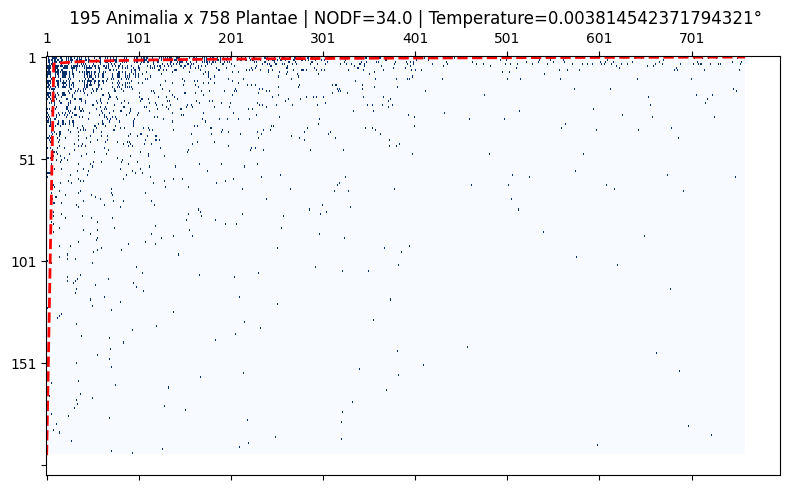

In [13]:
plot_nestedness_for_subred('G_m_anpl', subsubredes_mutualistas)  # Animalia-Plantae

0.4166666666666667
1.25 1.6666666666666667
(-0.26653802710100805, -0.34690659740877466, -1.7057716257322395e-12, -0.08036857030947234, 1.2499989885411917, 1.2500036863468011, -3.0597746558669314e-13, -5.940758995848228e-11)


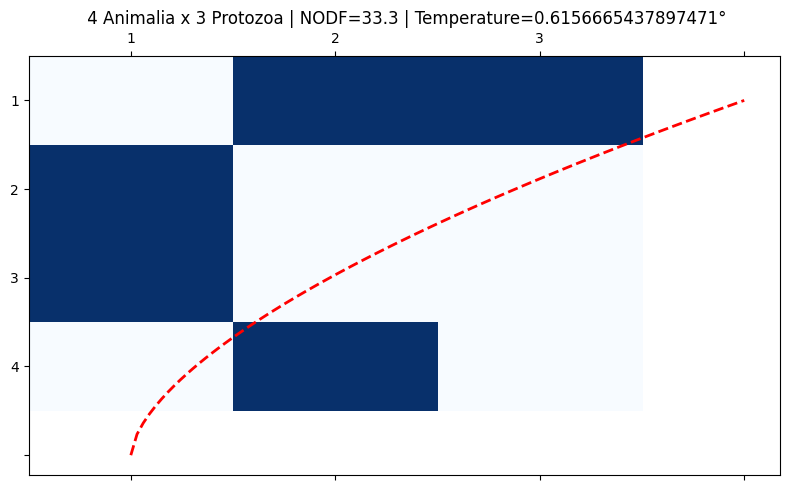

In [14]:
plot_nestedness_for_subred('G_p_anpr', subsubredes_mutualistas)  # Animalia-Plantae

0.023593073593073593
1.4155844155844155 1.8166666666666667
(-25.33726083499775, -52.539856492010856, -9.081946574290164e-08, -27.202595747832575, 1.415579900397593, 1.4163504256443389, -2.793195299499729e-06, 2.5557285843191835e-08)


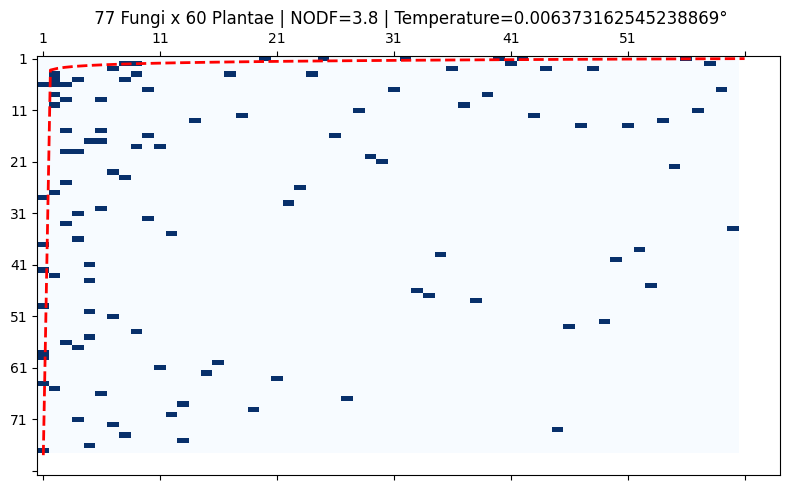

In [15]:
plot_nestedness_for_subred('G_p_fupl', subsubredes_mutualistas)  # Animalia-Plantae

0.13
2.6 1.3
(-6.508679763388132, -9.864647120742786, -1.10449102979347e-11, -3.3559673573656994, 2.5999993219853716, 2.60001172445816, -3.1561928026668795e-07, -3.671207782218744e-09)


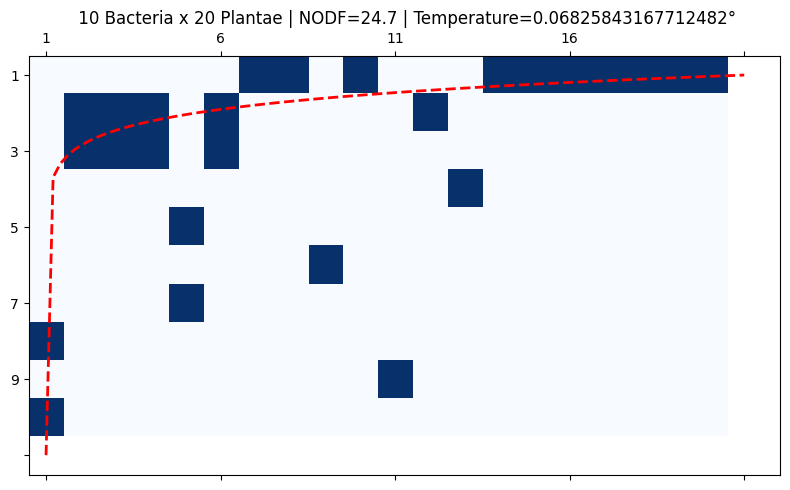

In [16]:
plot_nestedness_for_subred('G_p_bapl', subsubredes_mutualistas)  # Animalia-Plantae

1.0
1.0 1.0


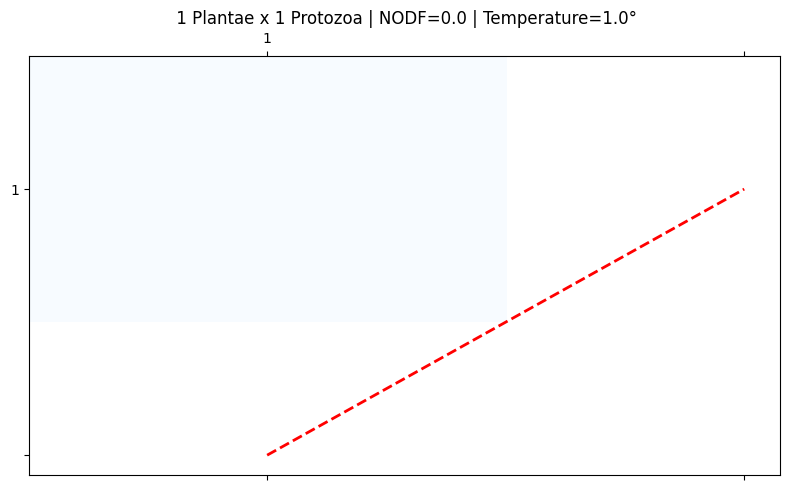

In [17]:
plot_nestedness_for_subred('G_p_plpr', subsubredes_mutualistas)  # Animalia-Plantae

### Prueba de anidamiento para las redes completas (sin hacer filtro de mutualismo) (CREO QUE YA NO LO VAMOS A USAR)

In [18]:
# 2. Para las redes completas (G, G_r, G_o, G_ro)
grafos_completos = {
    'G': G,
    'G_r': G_r,
    'G_o': G_o,
    'G_ro': G_ro
}
subsubredes_completas = crear_subsubredes_para_todos_pares(grafos_completos)

print("\n=== Subredes Completas ===")
tabla_completa = generar_tabla_subsubredes(subsubredes_completas)
print(tabla_completa)


=== Subredes Completas ===
           Nodos  Aristas  Componentes Tamaño componente gigante
Subsubred                                                       
G_bare         3        2            1                3 (100.0%)
G_anan       417      497           26               346 (83.0%)
G_bapl        55       57           10                18 (32.7%)
G_anba        47       46            7                16 (34.0%)
G_anfu        25       19            6                 6 (24.0%)
...          ...      ...          ...                       ...
G_ro_anch      2        1            1                2 (100.0%)
G_ro_fure     16       14            2                12 (75.0%)
G_ro_plre     30       23           10                 7 (23.3%)
G_ro_fupl     61       62            8                38 (62.3%)
G_ro_plpl    178      241           11               156 (87.6%)

[64 rows x 4 columns]


0.12179487179487179
1.4615384615384615 1.5833333333333333
(-4.810864152024902, -7.3734466933263, -1.1403269759624981e-10, -2.5625825414154306, 1.4615371576364407, 1.4615642763666727, -1.0388892790480497e-06, -4.234967732053008e-08)


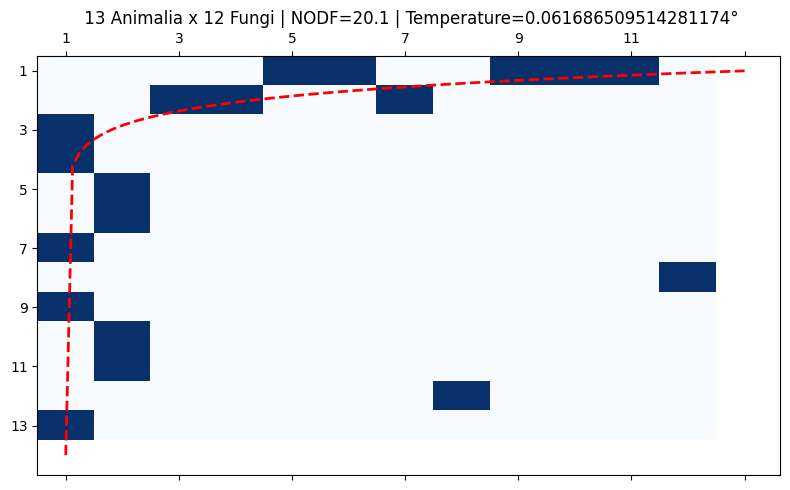

In [19]:
plot_nestedness_for_subred('G_anfu', subsubredes_completas)  # Animalia-Fungi

0.08333333333333333
2.0 1.9166666666666665
(-11.988472041785084, -19.656764047241076, -5.975358731073637e-11, -7.668292005515744, 1.9999993930327502, 2.000020460809299, -4.466723999563271e-07, -4.231532946263883e-08)


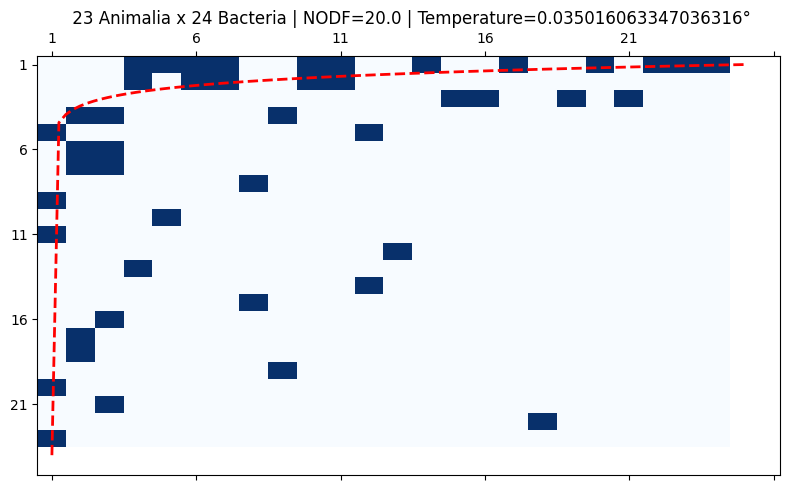

In [20]:
plot_nestedness_for_subred('G_anba', subsubredes_completas)  # Animalia-Fungi

0.625
2.5 1.25


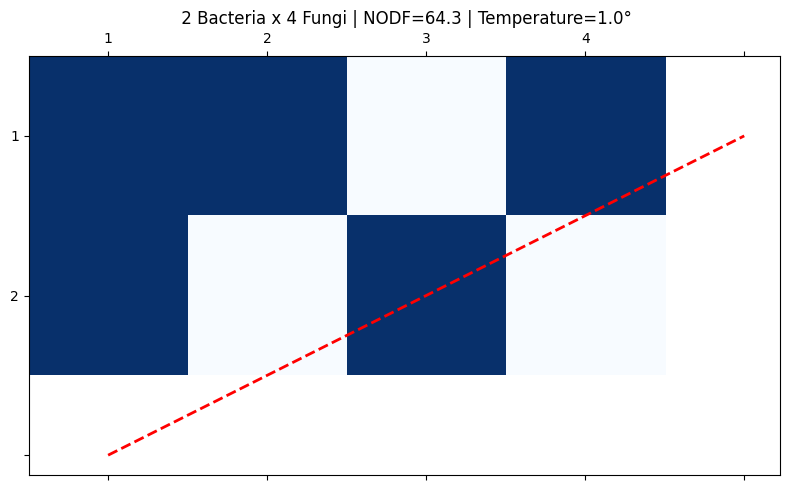

In [21]:
plot_nestedness_for_subred('G_r_bafu', subsubredes_completas)  # Bacteria-Fungi

## 3. Redes Nativas y No nativas

### Generar sub grafos nn (Nativa-Nativa), no (Nativa-No nativa), on (No nativa-Nativa) y oo (No nativa-No nativa)

In [22]:
import pandas as pd
import networkx as nx

TIPOS_ORIGEN = {
    'nn': 'Nativa-Nativa',
    'no': 'Nativa-No nativa',
    'on': 'No nativa-Nativa',
    'oo': 'No nativa-No nativa'
}

def filtrar_redes_por_origen(G_o):
    """
    Filtra las redes en subredes por tipo de interacción de origen
    Devuelve diccionarios con las subredes para G_o y G_ro
    """
    def _filtrar(grafo, prefijo):
        subredes = {f'{prefijo}_{tipo}': grafo.__class__() for tipo in TIPOS_ORIGEN}
        
        for u, v, data in grafo.edges(data=True):
            origen = data.get('origen', '')
            
            # Asignar a la subred correspondiente
            for tipo, patron in TIPOS_ORIGEN.items():
                if origen == patron:
                    # Agregar solo nodos involucrados en estas aristas
                    subred = subredes[f'{prefijo}_{tipo}']
                    if not subred.has_node(u):
                        subred.add_node(u, **grafo.nodes[u])
                    if not subred.has_node(v):
                        subred.add_node(v, **grafo.nodes[v])
                    subred.add_edge(u, v, **data)
                    break
        
        return subredes
    
    # Aplicar a todas las redes
    subredes_G_o = _filtrar(G_o, 'G_o')
    #subredes_G_ro = _filtrar(G_ro, 'G_ro')
    
    return _filtrar(G_o, 'G_o') #,  _filtrar(G_ro, 'G_ro')

def generar_tabla_comparativa(subredes):
    """
    Genera tabla comparativa con métricas básicas de las subredes
    
    Args:
        subredes: Diccionario de {nombre: grafo}
    
    Returns:
        DataFrame con las métricas
    """
    metricas = []
    
    for nombre, grafo in subredes.items():
        if grafo.number_of_nodes() == 0:
            continue
            
        # Componente gigante
        componente_gigante = max(nx.weakly_connected_components(grafo), key=len) if grafo.is_directed() else max(nx.connected_components(grafo), key=len)
        tamano_gigante = len(componente_gigante)
        porcentaje_gigante = (tamano_gigante / grafo.number_of_nodes()) * 100
        
        
        metricas.append({
            'Subred': nombre,
            'Nodos': grafo.number_of_nodes(),
            'Aristas': grafo.number_of_edges(),
            'Densidad': nx.density(grafo),
            'Tamaño componente gigante': f"{tamano_gigante} ({porcentaje_gigante:.1f}%)"
        })
    
    return pd.DataFrame(metricas).set_index('Subred')


# Combinar todas las subredes
#subredes_G_o, subredes_G_ro = filtrar_redes_por_origen(G_o, G_ro)
subredes_G_o = filtrar_redes_por_origen(G_o)
#todas_subredes = {**subredes_G_o, **subredes_G_ro}

# Generar tabla comparativa
tabla_comparativa = generar_tabla_comparativa(subredes_G_o)
print(tabla_comparativa)


        Nodos  Aristas  Densidad Tamaño componente gigante
Subred                                                    
G_o_nn    972     1980  0.002098               918 (94.4%)
G_o_no    738     1346  0.002475               685 (92.8%)
G_o_on    398      490  0.003101               347 (87.2%)
G_o_oo    653     1540  0.003617               649 (99.4%)


In [37]:
import networkx as nx

# Obtener los subgrafos del diccionario subredes_G_o
G_o_nn = subredes_G_o['G_o_nn']  # Nativa -> Nativa
G_o_no = subredes_G_o['G_o_no']  # Nativa -> No nativa
G_o_on = subredes_G_o['G_o_on']  # No nativa -> Nativa
G_o_oo = subredes_G_o['G_o_oo']  # No nativa -> No nativa

# Función mejorada para combinar grafos preservando atributos
def combinar_subgrafos(grafo1, grafo2):
    """Combina dos grafos dirigidos preservando todos los atributos"""
    grafo_combinado = grafo1.copy()
    
    # Añadir nodos faltantes con sus atributos
    for nodo in grafo2.nodes():
        if not grafo_combinado.has_node(nodo):
            grafo_combinado.add_node(nodo, **grafo2.nodes[nodo])
    
    # Añadir todas las aristas del segundo grafo
    grafo_combinado.add_edges_from(grafo2.edges(data=True))
    
    return grafo_combinado

# Crear grafos combinados
G_o_n = combinar_subgrafos(G_o_nn, G_o_no)  # Todas las interacciones que parten de nativas
G_o_o = combinar_subgrafos(G_o_on, G_o_oo)  # Todas las interacciones que parten de no nativas

# Verificación exhaustiva
def verificar_combinacion(grafo_comb, grafo1, grafo2):
    nodos_esperados = set(grafo1.nodes()) | set(grafo2.nodes())
    aristas_esperadas = grafo1.number_of_edges() + grafo2.number_of_edges()
    
    assert set(grafo_comb.nodes()) == nodos_esperados, "Error en nodos combinados"
    assert grafo_comb.number_of_edges() == aristas_esperadas, "Error en aristas combinadas"
    print("✓ Combinación verificada correctamente")

print("\nVerificación para G_o_n:")
verificar_combinacion(G_o_n, G_o_nn, G_o_no)

print("\nVerificación para G_o_o:")
verificar_combinacion(G_o_o, G_o_on, G_o_oo)

# Resultados finales
print(f"\nG_o_n: {G_o_n.number_of_nodes()} nodos, {G_o_n.number_of_edges()} aristas (Nativas como origen)")
print(f"G_o_o: {G_o_o.number_of_nodes()} nodos, {G_o_o.number_of_edges()} aristas (No nativas como origen)")

# Opcional: Guardar los grafos combinados si es necesario
# nx.write_graphml(G_o_n, "G_o_n.graphml")
# nx.write_graphml(G_o_o, "G_o_o.graphml")


Verificación para G_o_n:
✓ Combinación verificada correctamente

Verificación para G_o_o:
✓ Combinación verificada correctamente

G_o_n: 1500 nodos, 3326 aristas (Nativas como origen)
G_o_o: 1000 nodos, 2030 aristas (No nativas como origen)


### Frecuencia de tipo de interacciones de cada subred

Frecuencias absolutas de tipos de interacción:
        ALELOPATÍA  DEPREDACIÓN  DISPERSIÓN  EPIBIOSIS  HEMATOFAGIA  \
G_o_nn           3           84         182        212            1   
G_o_no           4           58          23         86            1   
G_o_on           3           28           2          3            0   
G_o_oo           9           20           3         67           20   

        HERBIVORÍA  MUTUALISMO  NIDIFICACIÓN  OTRAS INTERACCIONES  \
G_o_nn         671           1            21                   35   
G_o_no         432           0            17                    5   
G_o_on         166           1             0                    7   
G_o_oo        1018           0             0                    3   

        OVIPOSICIÓN  PARASITISMO  VISITA FLORAL  
G_o_nn          137           17            932  
G_o_no          232            9            713  
G_o_on           10           21            258  
G_o_oo           73           50            351  



<Figure size 1200x800 with 0 Axes>

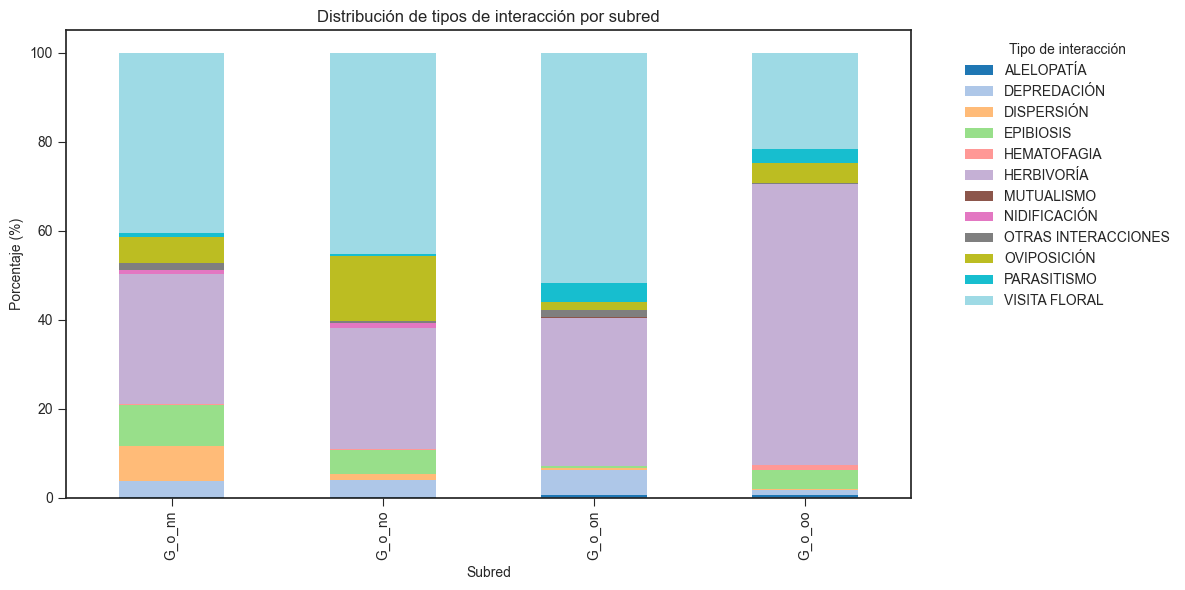

In [26]:
def calcular_frecuencia_interacciones(subredes):
    """
    Calcula la frecuencia de tipos de interacción para cada subred
    
    Args:
        subredes: Diccionario de {nombre: grafo}
    
    Returns:
        DataFrame con frecuencias por subred
    """
    # Primero recolectamos todos los tipos de interacción únicos
    todos_tipos = set()
    for nombre, grafo in subredes.items():
        for u, v, data in grafo.edges(data=True):
            todos_tipos.update(data['interacciones'].split(", "))
    
    # Creamos un DataFrame para almacenar los resultados
    df_frecuencias = pd.DataFrame(0, index=subredes.keys(), columns=sorted(todos_tipos))
    
    # Contamos las ocurrencias en cada subred
    for nombre, grafo in subredes.items():
        for u, v, data in grafo.edges(data=True):
            for tipo in data['interacciones'].split(", "):
                df_frecuencias.loc[nombre, tipo] += 1
    
    # Convertimos a frecuencias relativas (porcentajes)
    df_porcentajes = df_frecuencias.div(df_frecuencias.sum(axis=1), axis=0) * 100
    
    return df_frecuencias, df_porcentajes

# Aplicamos la función a nuestras subredes
frecuencias_abs, frecuencias_rel = calcular_frecuencia_interacciones(subredes_G_o)

print("Frecuencias absolutas de tipos de interacción:")
print(frecuencias_abs)

print("\nFrecuencias relativas (%):")
print(frecuencias_rel.round(1))

# Visualización
plt.figure(figsize=(12, 8))
frecuencias_rel.plot(kind='bar', stacked=True, colormap='tab20', figsize=(12, 6))
plt.title('Distribución de tipos de interacción por subred')
plt.ylabel('Porcentaje (%)')
plt.xlabel('Subred')
plt.legend(title='Tipo de interacción', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('FrecuenciaInteraciones.png')
plt.show()

Frecuencias absolutas de tipos de interacción:
       ALELOPATÍA  DEPREDACIÓN  DISPERSIÓN  EPIBIOSIS  HEMATOFAGIA  \
G_o_n           7          142         205        298            2   
G_o_o          12           48           5         70           20   

       HERBIVORÍA  MUTUALISMO  NIDIFICACIÓN  OTRAS INTERACCIONES  OVIPOSICIÓN  \
G_o_n        1103           1            38                   40          369   
G_o_o        1184           1             0                   10           83   

       PARASITISMO  VISITA FLORAL  
G_o_n           26           1645  
G_o_o           71            609  

Frecuencias relativas (%):
       ALELOPATÍA  DEPREDACIÓN  DISPERSIÓN  EPIBIOSIS  HEMATOFAGIA  \
G_o_n         0.2          3.7         5.3        7.7          0.1   
G_o_o         0.6          2.3         0.2        3.3          0.9   

       HERBIVORÍA  MUTUALISMO  NIDIFICACIÓN  OTRAS INTERACCIONES  OVIPOSICIÓN  \
G_o_n        28.5         0.0           1.0                  1.0      

<Figure size 1200x600 with 0 Axes>

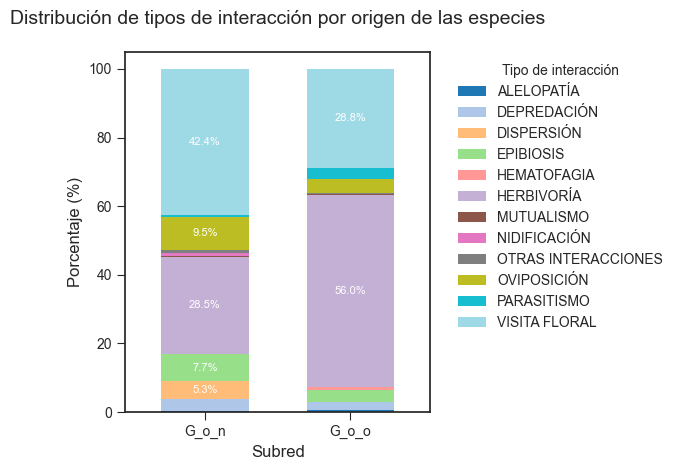

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

def calcular_frecuencia_interacciones(G_o_n, G_o_o):
    """
    Calcula la frecuencia de tipos de interacción para G_o_n y G_o_o
    
    Args:
        G_o_n: Grafo de interacciones que parten de especies nativas
        G_o_o: Grafo de interacciones que parten de especies no nativas
    
    Returns:
        DataFrame con frecuencias por subred
    """
    # Diccionario con los grafos a analizar
    subredes = {
        'G_o_n': G_o_n,
        'G_o_o': G_o_o
    }
    
    # Recolectamos todos los tipos de interacción únicos
    todos_tipos = set()
    for nombre, grafo in subredes.items():
        for u, v, data in grafo.edges(data=True):
            if 'interacciones' in data:
                todos_tipos.update(data['interacciones'].split(", "))
    
    # DataFrame para resultados
    df_frecuencias = pd.DataFrame(0, index=subredes.keys(), columns=sorted(todos_tipos))
    
    # Contamos las ocurrencias
    for nombre, grafo in subredes.items():
        for u, v, data in grafo.edges(data=True):
            if 'interacciones' in data:
                for tipo in data['interacciones'].split(", "):
                    df_frecuencias.loc[nombre, tipo] += 1
    
    # Convertimos a porcentajes
    df_porcentajes = df_frecuencias.div(df_frecuencias.sum(axis=1), axis=0) * 100
    
    return df_frecuencias, df_porcentajes

# Aplicamos la función
frecuencias_abs, frecuencias_rel = calcular_frecuencia_interacciones(G_o_n, G_o_o)

print("Frecuencias absolutas de tipos de interacción:")
print(frecuencias_abs)

print("\nFrecuencias relativas (%):")
print(frecuencias_rel.round(1))

# Visualización mejorada
plt.figure(figsize=(12, 6))
ax = frecuencias_rel.plot(kind='bar', 
                         stacked=True, 
                         colormap='tab20', 
                         width=0.6)
                         #edgecolor='black')

plt.title('Distribución de tipos de interacción por origen de las especies', fontsize=14, pad=20)
plt.ylabel('Porcentaje (%)', fontsize=12)
plt.xlabel('Subred', fontsize=12)
plt.xticks(rotation=0)

# Leyenda fuera del gráfico
plt.legend(title='Tipo de interacción', 
           bbox_to_anchor=(1.05, 1), 
           loc='upper left',
           fontsize=10)

# Añadir etiquetas de porcentaje
for rect in ax.patches:
    height = rect.get_height()
    if height > 5:  # Solo mostrar porcentajes >5% para mayor claridad
        ax.text(rect.get_x() + rect.get_width()/2, 
                rect.get_y() + height/2,
                f'{height:.1f}%', 
                ha='center', 
                va='center',
                color='white',
                fontsize=8)

plt.tight_layout()
plt.savefig('FrecuenciaInteracciones_Nativas_vs_NoNativas.png', dpi=300, bbox_inches='tight')
plt.show()

In [41]:
# Para encontrar los tipos de interacción más distintivos de cada subred
def interacciones_caracteristicas(df_frecuencias):
    # Normalizamos por el total de interacciones en cada subred
    df_norm = df_frecuencias.div(df_frecuencias.sum(axis=1), axis=0)
    
    # Calculamos la media global de cada interacción
    media_global = df_frecuencias.sum() / df_frecuencias.sum().sum()
    
    # Encontramos las más distintivas (mayor diferencia respecto a la media)
    resultados = {}
    for subred in df_norm.index:
        diferencias = (df_norm.loc[subred] - media_global).sort_values(ascending=False)
        resultados[subred] = diferencias.head(3)  # Top 3 interacciones más características
    
    return pd.DataFrame(resultados).T

print("\n3 Interacciones más características por subred:")
print(interacciones_caracteristicas(frecuencias_abs))


3 Interacciones más características por subred:
       DISPERSIÓN  HEMATOFAGIA  HERBIVORÍA  OVIPOSICIÓN  PARASITISMO  \
G_o_n    0.017825          NaN         NaN      0.01973          NaN   
G_o_o         NaN     0.005792    0.178474          NaN     0.017405   

       VISITA FLORAL  
G_o_n        0.04805  
G_o_o            NaN  


In [27]:
# Para encontrar los tipos de interacción más distintivos de cada subred
def interacciones_caracteristicas(df_frecuencias):
    # Normalizamos por el total de interacciones en cada subred
    df_norm = df_frecuencias.div(df_frecuencias.sum(axis=1), axis=0)
    
    # Calculamos la media global de cada interacción
    media_global = df_frecuencias.sum() / df_frecuencias.sum().sum()
    
    # Encontramos las más distintivas (mayor diferencia respecto a la media)
    resultados = {}
    for subred in df_norm.index:
        diferencias = (df_norm.loc[subred] - media_global).sort_values(ascending=False)
        resultados[subred] = diferencias.head(3)  # Top 3 interacciones más características
    
    return pd.DataFrame(resultados).T

print("\n3 Interacciones más características por subred:")
print(interacciones_caracteristicas(frecuencias_abs))


3 Interacciones más características por subred:
        DEPREDACIÓN  DISPERSIÓN  EPIBIOSIS  HEMATOFAGIA  HERBIVORÍA  \
G_o_nn          NaN    0.044204   0.030889          NaN         NaN   
G_o_no     0.004984         NaN        NaN          NaN         NaN   
G_o_on     0.024387         NaN        NaN          NaN         NaN   
G_o_oo          NaN         NaN        NaN     0.008718    0.248864   

        OVIPOSICIÓN  PARASITISMO  VISITA FLORAL  
G_o_nn          NaN          NaN       0.029567  
G_o_no     0.071364          NaN       0.074909  
G_o_on          NaN     0.025888       0.140677  
G_o_oo          NaN     0.014783            NaN  


Explicación de la métrica:
Valores positivos: Indican que la interacción es más frecuente en esa subred que en el promedio global.

NaN: Significa que esa interacción no es característica de esa subred (frecuencia similar o menor al promedio).

Magnitud del valor: Cuanto mayor sea el número, más exclusiva es esa interacción para la subred.

Interpretación por subred:
G_o_nn (Nativa-Nativa):

DISPERSIÓN (0.053) y EPIBIOSIS (0.017) son las más características.

Sugiere que las interacciones entre especies nativas involucran principalmente dispersión de semillas y relaciones de epibiosis.

G_o_no (Nativa-No nativa):

DEPREDACIÓN (0.004) y OVIPOSICIÓN (0.075) dominan.

Indica que cuando interactúan nativas con no nativas, predominan relaciones antagonistas (depredación) y de parasitismo (oviposición).

G_o_on (No nativa-Nativa):

DEPREDACIÓN (0.024) y PARASITISMO (0.026) son clave.

Refleja que las no nativas actúan como depredadores/parásitos de las nativas.

G_o_oo (No nativa-No nativa):

HERBIVORÍA (0.311) y HEMATOFAGIA (0.009) sobresalen.

Muestra que las no nativas interactúan principalmente mediante herbivoría entre ellas, con algo de hematofagia.

G_ro_nn (Reportadas - Nativa-Nativa):

EPIBIOSIS (0.037) y VISITA FLORAL (0.094).

En interacciones reportadas entre nativas, son importantes las visitas florales (polinización) y epibiosis.

G_ro_no (Reportadas - Nativa-No nativa):

VISITA FLORAL (0.193) y DEPREDACIÓN (0.004).

Contraintuitivamente, muestra mutualismo (visitas florales) en interacciones reportadas, pero con bajo nivel de depredación.

G_ro_on (Reportadas - No nativa-Nativa):

PARASITISMO (0.063) y OTRAS INTERACCIONES (0.032).

Confirma el rol parasitario de no nativas sobre nativas en interacciones reportadas.

G_ro_oo (Reportadas - No nativa-No nativa):

EPIBIOSIS (0.120) y PARASITISMO (0.051).

Interacciones complejas con alto nivel de epibiosis y parasitismo entre no nativas.

### Distribución de grado de cada subred

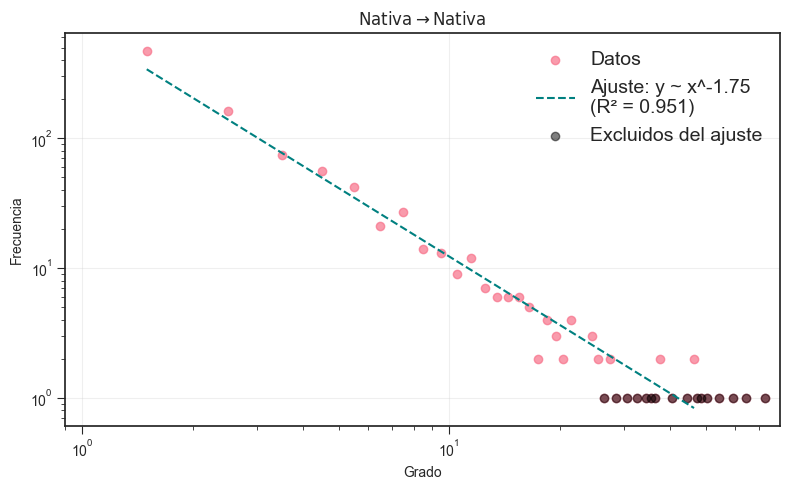

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
%matplotlib inline

class AutoDegreePlotter:
    def __init__(self, grafo, nombre):
        self.grafo = grafo
        self.nombre = nombre
        
        # Calcular distribución de grados
        degrees = [d for _, d in grafo.degree()]
        hist, bins = np.histogram(degrees, bins=np.arange(0, max(degrees)+2), density=False)
        self.x = (bins[:-1] + bins[1:])/2
        self.y = hist
        mask = hist > 0  # Eliminar bins vacíos
        self.x = self.x[mask]
        self.y = self.y[mask]
        
        # Configurar figura
        self.fig, self.ax = plt.subplots(figsize=(8, 5))
        
        # Graficar todos los puntos
        self.scatter = self.ax.scatter(self.x, self.y, label='Datos', alpha=0.7)
        
        # Ajuste automático excluyendo puntos con frecuencia = 1
        self.perform_auto_fit()
        
        # Configuración del gráfico
        self.ax.set_xscale('log')
        self.ax.set_yscale('log')
        self.ax.set_xlim(0.9, max(self.x)*1.1)
        self.ax.set_title(f'{nombre}')
        self.ax.set_xlabel('Grado')
        self.ax.set_ylabel('Frecuencia')
        self.ax.grid(True, alpha=0.3)
        self.ax.legend(fontsize=14)

        plt.savefig(f'{grafo}.png')
        plt.tight_layout()
        plt.show()
    
    def perform_auto_fit(self):
        """Realiza el ajuste automático excluyendo puntos con frecuencia = 1"""
        # Filtrar puntos con frecuencia > 1
        mask = self.y > min(self.y)
        fit_x = self.x[mask]
        fit_y = self.y[mask]
        
        if len(fit_x) >= 2:
            # Ajuste lineal en log-log
            log_x = np.log10(fit_x)
            log_y = np.log10(fit_y)
            slope, intercept, r_value, _, _ = linregress(log_x, log_y)
            r_squared = r_value**2
            
            # Calcular línea de ajuste para todos los puntos
            y_fit = 10**(slope * np.log10(fit_x) + intercept)
            
            # Graficar línea de ajuste
            self.ax.plot(fit_x, y_fit, '--', color='teal',
                        label=f'Ajuste: y ~ x^{slope:.2f}\n(R² = {r_squared:.3f})')
            
            # Resaltar puntos excluidos del ajuste
            excluded_mask = ~mask
            if any(excluded_mask):
                self.ax.scatter(self.x[excluded_mask], self.y[excluded_mask], 
                              color='black', alpha=0.5, label='Excluidos del ajuste')
        else:
            self.ax.text(0.5, 0.5, 'No hay suficientes puntos para el ajuste',
                        ha='center', va='center', transform=self.ax.transAxes)

# Uso:
# 1. Primero ejecuta esto en una celda:
%matplotlib inline

# 2. Luego en otra celda visualiza cada red:
plotter = AutoDegreePlotter(subredes_G_o['G_o_nn'], r'$\text{Nativa} \rightarrow \text{Nativa}$')

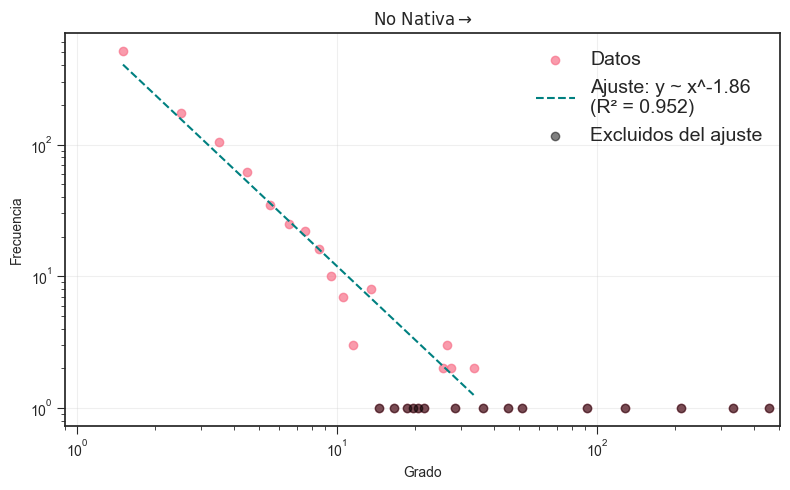

In [46]:
plotter = AutoDegreePlotter(G_o_o,  r'$\text{No Nativa} \rightarrow$')

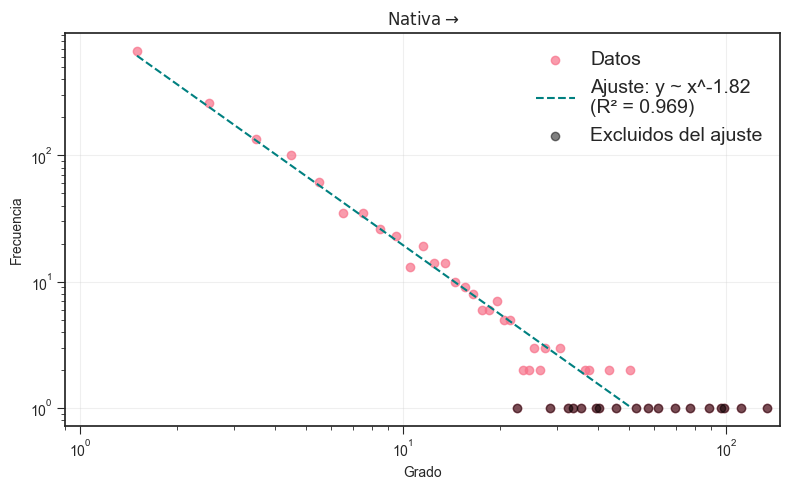

In [45]:
plotter = AutoDegreePlotter(G_o_n,  r'$\text{Nativa} \rightarrow$')

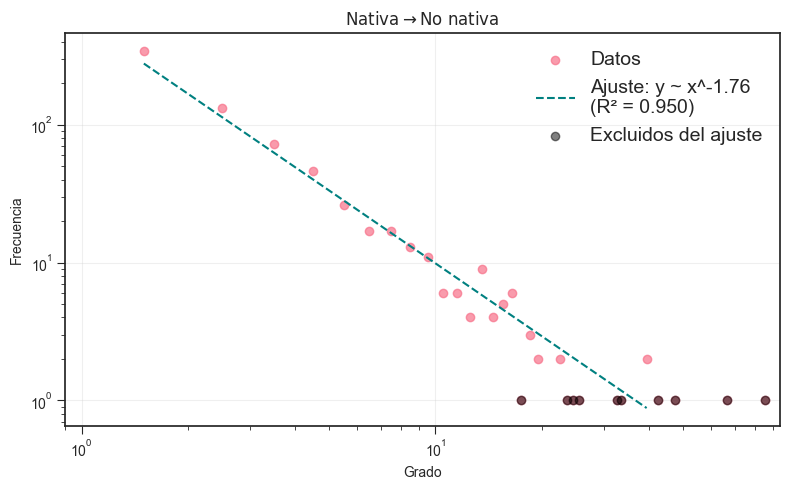

In [29]:
plotter = AutoDegreePlotter(subredes_G_o['G_o_no'],  r'$\text{Nativa} \rightarrow \text{No nativa}$')

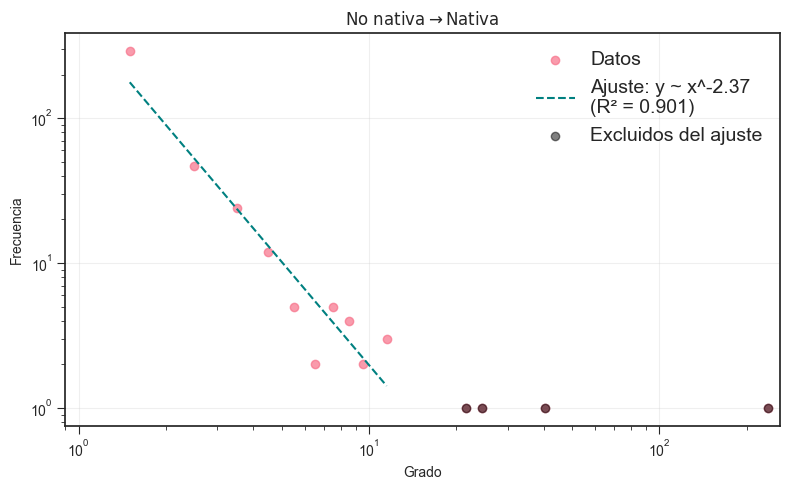

In [30]:
plotter = AutoDegreePlotter(subredes_G_o['G_o_on'],  r'$\text{No nativa} \rightarrow \text{Nativa}$')

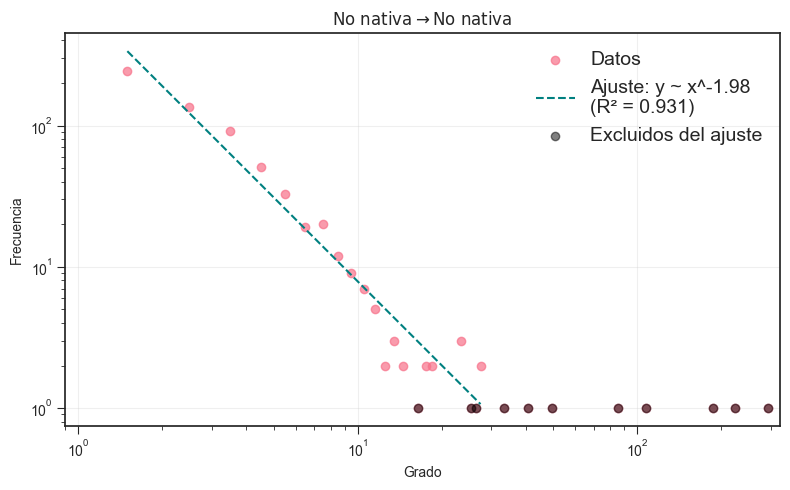

In [31]:
plotter = AutoDegreePlotter(subredes_G_o['G_o_oo'],  r'$\text{No nativa} \rightarrow \text{No nativa}$')

### test de KS

In [32]:
from scipy import stats
import itertools

def realizar_ks_test_entre_subredes(subredes):
    """
    Realiza pruebas KS entre todas las combinaciones de subredes de un mismo tipo (G_o o G_ro)
    """
    
    # Obtener todas las combinaciones posibles de pares de subredes
    combinaciones = list(itertools.combinations(subredes.keys(), 2))
    
    resultados = []
    
    for subred1, subred2 in combinaciones:
        # Obtener listas de grados
        grados1 = [d for _, d in subredes[subred1].degree()]
        grados2 = [d for _, d in subredes[subred2].degree()]
        
        # Realizar test KS
        ks_stat, p_value = stats.ks_2samp(grados1, grados2)
        
        resultados.append({
            'Comparación': f"{subred1} vs {subred2}",
            'Estadístico KS': ks_stat,
            'p-valor': p_value,
            'Significativo (p < 0.05)': p_value < 0.05
        })
    
    return pd.DataFrame(resultados)

# Realizar pruebas para G_o
print("=== Resultados KS test para subredes G_o ===")
df_ks_g_o = realizar_ks_test_entre_subredes(subredes_G_o)
display(df_ks_g_o)

# Realizar pruebas para G_ro
#print("\n=== Resultados KS test para subredes G_ro ===")
#df_ks_g_ro = realizar_ks_test_entre_subredes(subredes_G_ro)
#display(df_ks_g_ro)

=== Resultados KS test para subredes G_o ===


,Comparación,Estadístico KS,p-valor,Significativo (p < 0.05)
0,G_o_nn vs G_o_no,0.022282,9.814918e-01,False
1,G_o_nn vs G_o_on,0.245104,2.141789e-15,True
2,G_o_nn vs G_o_oo,0.109879,1.438926e-04,True
3,G_o_no vs G_o_on,0.263874,2.438633e-16,True
4,G_o_no vs G_o_oo,0.091110,5.837224e-03,True
5,G_o_on vs G_o_oo,0.354983,3.301032e-28,True


Interpretación de los resultados:
Estadístico KS: Mide la máxima distancia entre las funciones de distribución acumulada (CDF) de las dos muestras.

Rango: 0 (iguales) a 1 (totalmente diferentes)

Valores > 0.2 generalmente indican diferencias importantes

p-valor:

p < 0.05: Diferencias estadísticamente significativas

p ≥ 0.05: No hay evidencia suficiente para afirmar diferencias

### Métricas de centralidad (Conclusión de acá: no hay diferencias apreciables en la distribución de la centralidad de las especies Nativas o No Nativas)

In [33]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import linregress

# Configuración de estilo
plt.style.use('seaborn-v0_8-ticks')
sns.set_palette("husl")
plt.rcParams['figure.facecolor'] = 'white'

class NetworkAnalyzer:
    def __init__(self, grafos, nombres_grafos):
        self.grafos = grafos
        self.nombres_grafos = nombres_grafos
        self.df_metricas = None
        
    def clasificar_nodos(self, grafo):
        """Clasifica nodos como Nativos o No-Nativos basado en las aristas"""
        clasificacion = {}
        
        for u, v, data in grafo.edges(data=True):
            origen = data.get('origen', '')
            
            if origen == 'Nativa-Nativa':
                clasificacion[u] = clasificacion[v] = 'Nativo'
            elif origen == 'Nativa-No nativa':
                clasificacion[u], clasificacion[v] = 'Nativo', 'No-Nativo'
            elif origen == 'No nativa-Nativa':
                clasificacion[u], clasificacion[v] = 'No-Nativo', 'Nativo'
            elif origen == 'No nativa-No nativa':
                clasificacion[u] = clasificacion[v] = 'No-Nativo'
        
        # Para nodos aislados (si los hay)
        for nodo in grafo.nodes():
            if nodo not in clasificacion:
                clasificacion[nodo] = grafo.nodes[nodo].get('origen', 'Desconocido').split('-')[0]
        
        return clasificacion
    
    def calcular_metricas(self):
        """Calcula métricas para cada nodo y clasifica por tipo"""
        resultados = []
        
        metricas_centralidad = {
            'Betweenness': nx.betweenness_centrality,
            'Closeness': nx.closeness_centrality,
            'PageRank': nx.pagerank,
            'Degree': nx.degree_centrality,
            'Eigenvector': lambda g: nx.eigenvector_centrality(g, max_iter=1000, tol=1e-4)
        }
        
        for grafo, nombre_grafo in zip(self.grafos, self.nombres_grafos):
            print(f"\nProcesando {nombre_grafo}...")
            
            # Clasificar nodos
            tipos_nodo = self.clasificar_nodos(grafo)
            
            # Calcular clustering
            clustering = nx.clustering(grafo)
            
            # Calcular cada centralidad
            centralidades = {}
            for nombre, funcion in tqdm(metricas_centralidad.items(), desc="Calculando centralidades"):
                try:
                    if nombre == 'Eigenvector':
                        try:
                            centralidades[nombre] = funcion(grafo)
                        except nx.PowerIterationFailedConvergence:
                            print("Eigenvector no convergió, usando valores por defecto")
                            centralidades[nombre] = {nodo: 0 for nodo in grafo.nodes()}
                    else:
                        centralidades[nombre] = funcion(grafo)
                except Exception as e:
                    print(f"Error en {nombre}: {str(e)}")
                    centralidades[nombre] = {nodo: 0 for nodo in grafo.nodes()}
            
            # Recolectar datos por nodo
            for nodo in tqdm(grafo.nodes(), desc="Procesando nodos"):
                datos = {
                    'Grafo': nombre_grafo,
                    'Nodo': nodo,
                    'Tipo': tipos_nodo.get(nodo, 'Desconocido'),
                    'Grado': grafo.degree(nodo),
                    'Clustering': clustering.get(nodo, 0)
                }
                
                # Agregar centralidades
                for nombre, valores in centralidades.items():
                    datos[nombre] = valores.get(nodo, 0)
                
                resultados.append(datos)
        
        self.df_metricas = pd.DataFrame(resultados)
        return self.df_metricas

# Crear y configurar el analizador
analyzer = NetworkAnalyzer(grafos=[G_o_n], nombres_grafos=['G_o_nn'])

# Calcular métricas y obtener DataFrame
df_metricas = analyzer.calcular_metricas()

# Mostrar las primeras filas del DataFrame
#display(df_metricas.head())

NameError: name 'G_o_nn' is not defined


Procesando Interacciones_Nativas...


Procesando nodos: 100%|████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 319120.26it/s]



Procesando Interacciones_No_Nativas...


Procesando nodos: 100%|████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<?, ?it/s]


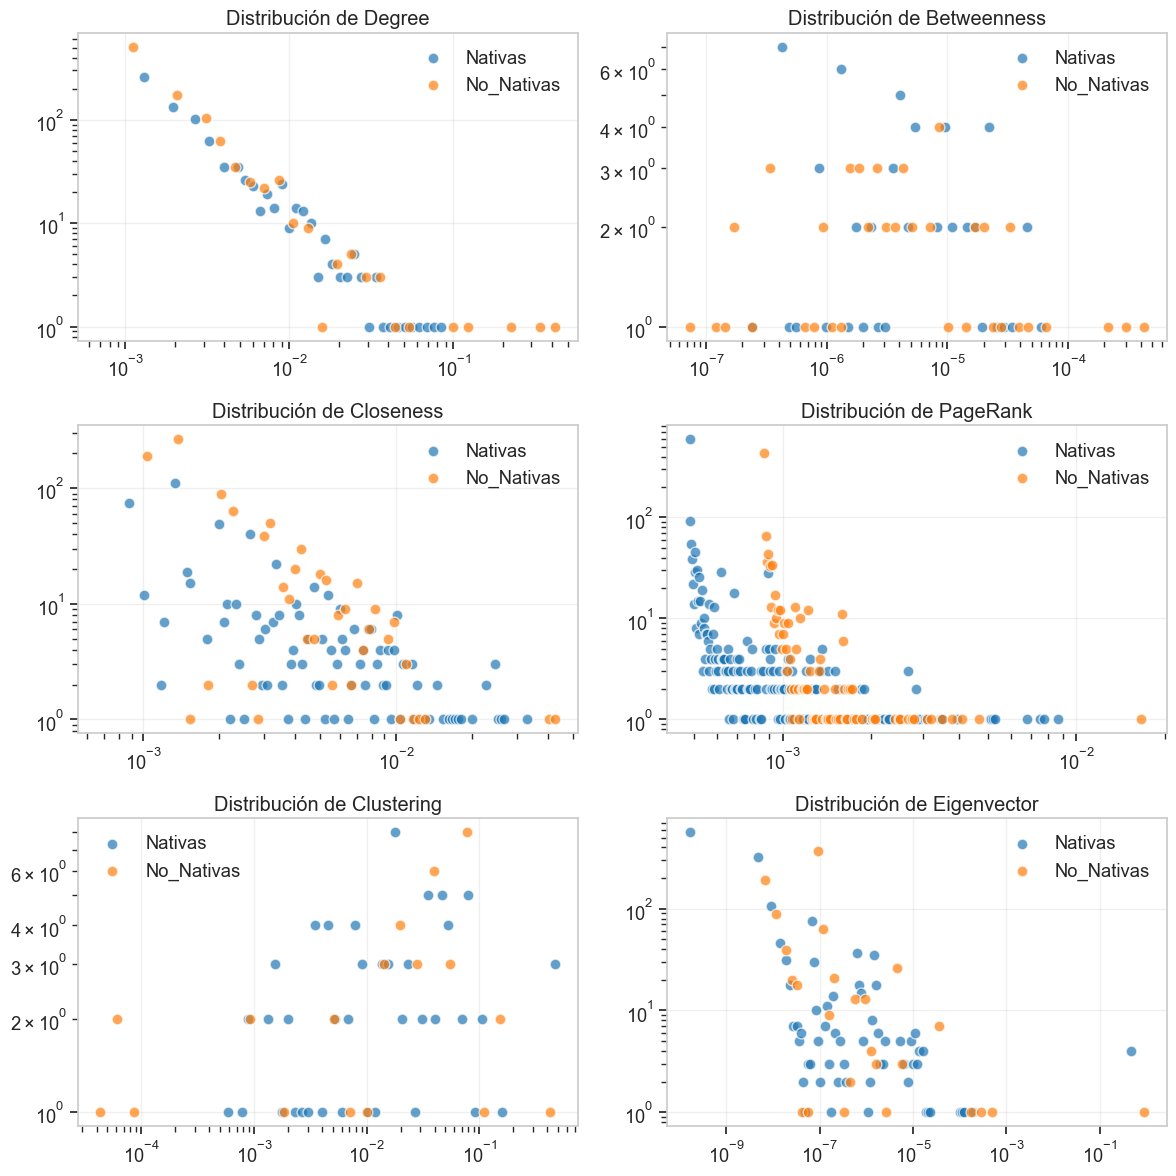

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress


class CentralityFrequencyPlotter:
    def __init__(self, G_o_n, G_o_o):
        self.grafos = {
            'Interacciones_Nativas': G_o_n,
            'Interacciones_No_Nativas': G_o_o
        }
        self.df_metricas = None
        
    def calcular_metricas(self):
        """Calcula métricas de centralidad para ambos grafos incluyendo Eigenvector"""
        resultados = []
        
        metricas_centralidad = {
            'Degree': nx.degree_centrality,
            'Betweenness': nx.betweenness_centrality,
            'Closeness': nx.closeness_centrality,
            'PageRank': nx.pagerank,
            'Clustering': nx.clustering,
            'Eigenvector': lambda g: nx.eigenvector_centrality(g, max_iter=1000, tol=1e-6)
        }
        
        for nombre_grafo, grafo in self.grafos.items():
            print(f"\nProcesando {nombre_grafo}...")
            
            # Calcular cada métrica
            metricas = {}
            for nombre, funcion in tqdm(metricas_centralidad.items(), desc="Calculando métricas"):
                try:
                    if nombre == 'Clustering':
                        metricas[nombre] = funcion(grafo)
                    elif nombre == 'Eigenvector':
                        try:
                            metricas[nombre] = funcion(grafo)
                        except nx.PowerIterationFailedConvergence:
                            print("Eigenvector no convergió, usando valores por defecto")
                            metricas[nombre] = {nodo: 0 for nodo in grafo.nodes()}
                    else:
                        metricas[nombre] = funcion(grafo, weight='weight') if grafo.is_multigraph() else funcion(grafo)
                except Exception as e:
                    print(f"Error en {nombre}: {str(e)}")
                    metricas[nombre] = {nodo: 0 for nodo in grafo.nodes()}
            
            # Recolectar datos por nodo
            for nodo in tqdm(grafo.nodes(), desc="Procesando nodos"):
                datos = {
                    'Grafo': nombre_grafo,
                    'Nodo': nodo
                }
                
                # Agregar métricas
                for nombre, valores in metricas.items():
                    datos[nombre] = valores.get(nodo, 0)
                
                resultados.append(datos)
        
        self.df_metricas = pd.DataFrame(resultados)
        return self.df_metricas
    
    def _calcular_bins(self, data, metrica):
        """Calcula bins adaptativos según la métrica y distribución de datos"""
        data_pos = data[data > 0]  # Filtramos valores no positivos
        #data_pos = data
        if len(data_pos) == 0:
            return np.array([0, 1])  # Bins por defecto para datos vacíos
        
        #min_val = max(1e-16, np.min(data_pos))  # Evita log(0)
        min_val = np.min(data_pos)
        max_val = np.max(data_pos)
        
        #if metrica == 'Clustering':
        #    return np.logspace(np.log10(min_val), np.log10(max_val), 15)
        #elif metrica == 'Betweenness':
        #    return np.logspace(np.log10(min_val), np.log10(max_val), 15)
        #elif metrica == 'Closeness':
        #    return np.logspace(np.log10(min_val), np.log10(max_val), 15)
        #elif metrica == 'Eigenvector':
        #    return np.logspace(np.log10(min_val), np.log10(max_val), 20)
        #elif metrica == 'PageRank':
        #    return np.logspace(np.log10(min_val), np.log10(max_val), 30)
        #else: 
        return np.logspace(np.log10(min_val), np.log10(max_val), len(np.unique(data)))

    def graficar_frecuencias_adaptativas(self, norm=True, ajuste=False):
        """Grafica frecuencias con bins adaptativos y manejo robusto de escalas"""
        if self.df_metricas is None:
            self.calcular_metricas()
        
        metricas = ['Degree', 'Betweenness', 'Closeness', 'PageRank', 'Clustering', 'Eigenvector']
        fig, axes = plt.subplots(3, 2, figsize=(12,12))
        axes = axes.ravel()  # Aplanamos el array 2D a 1D para facilitar el acceso
        colores = {'Interacciones_Nativas': '#1f77b4', 'Interacciones_No_Nativas': '#ff7f0e'}
    
        for idx, metrica in enumerate(metricas):
            ax = axes[idx]  # Accedemos al Axes correcto
            
            # Resto del código permanece igual...
            for grafo, color in colores.items():
                data = self.df_metricas[self.df_metricas['Grafo'] == grafo][metrica].values
                data_pos = data[data > 0]
                
                if len(data_pos) == 0:
                    print(f"Advertencia: No hay valores positivos para {metrica} en {grafo}")
                    continue
                
                # Cálculo adaptativo de bins
                bins = self._calcular_bins(data, metrica)
                counts, bins = np.histogram(data_pos, bins=bins, density=False)
                bins_centers = bins[:-1] + np.diff(bins)/2
                
                # Normalización
                counts_normalized = counts/counts.max() if norm and counts.max() > 0 else counts
                
                # Graficado
                ax.scatter(
                    bins_centers,
                    counts_normalized,
                    color=color,
                    label=grafo.replace('Interacciones_', ''),
                    alpha=0.7,
                    s=60,
                    edgecolor='w'
                )
                
                # Ajuste lineal si se solicita
                if ajuste and len(bins_centers) >= 2:
                    try:
                        mask = counts_normalized > 0
                        if mask.sum() >= 2:  # Mínimo 2 puntos para ajuste
                            slope, intercept, r_value, _, _ = linregress(
                                np.log10(bins_centers[mask]),
                                np.log10(counts_normalized[mask])
                            )
                            y_pred = 10**intercept * bins_centers**slope
                            ax.plot(bins_centers, y_pred, '--', color=color,
                                   label=f'$y \sim x^{{{slope:.2f}}}$ ($R^2$={r_value**2:.2f})')
                    except Exception as e:
                        print(f"Error en ajuste para {metrica} - {grafo}: {str(e)}")
            
            # Configuración del eje
            #if metrica in ['Betweenness', 'Degree', 'PageRank', 'Eigenvector']:
            ax.set_xscale('log')
             #   ax.set_xlabel(f'{metrica} (log scale)')
            #else:
             #   ax.set_xlabel(metrica)
            
            
            #ax.set_ylabel('Frecuencia relativa' if norm else 'Densidad')
            ax.set_yscale('log')
            ax.legend()
            ax.grid(True, alpha=0.3)
            ax.set_title(f'Distribución de {metrica}')
        
        plt.tight_layout()
        plt.savefig('Distribuciones_Centralidad.png', dpi=300, bbox_inches='tight')
        plt.show()

# Uso del plotter
plotter = CentralityFrequencyPlotter(G_o_n, G_o_o)
plotter.calcular_metricas()  # Asumiendo que esta función está definida como antes
plotter.graficar_frecuencias_adaptativas(norm=False, ajuste=False)

In [198]:
def graficar_distribucion(metrica, log_scale=True, ajuste=True, norm=True):
    """Grafica distribuciones con opción de ajuste lineal en escala log-log
    
    Parámetros:
    -----------
    metrica : str
        Nombre de la métrica a graficar ('Grado', 'Betweenness', 'Clustering', etc.)
    log_scale : bool, optional
        Si True (default), usa escala log-log. Si False, escala lineal.
    ajuste : bool, optional
        Si True (default), realiza y muestra el ajuste lineal. Si False, omite el ajuste.
    """
    plt.figure(figsize=(8, 4))
    
    plot_data = analyzer.df_metricas[analyzer.df_metricas['Tipo'].isin(['Nativo', 'No-Nativo'])]
    
    for grafo in analyzer.nombres_grafos:
        for tipo in ['Nativo', 'No-Nativo']:
            subset = plot_data[(plot_data['Grafo'] == grafo) & (plot_data['Tipo'] == tipo)]
            if not subset.empty:
                data = subset[metrica].values
                data = data[data > 0]  # Filtrar ceros
                
                if len(data) > 0:
                    # Configuración de bins según la métrica
                    if metrica == 'Clustering':
                        bins = np.logspace(np.log10(max(1e-5, min(data))), np.log10(1), 20)
                    else:
                        bins = np.logspace(np.log10(max(1e-5, min(data))), np.log10(max(data)), 20)
                    
                    counts, bins = np.histogram(data, bins=bins, density=True)
                    bins_centers = bins[:-1] + np.diff(bins)/2

                    if norm:
                        counts_normalized = counts / counts.max() 
                    else:
                        counts_normalized = counts
                    
                    # Graficar puntos
                    plt.scatter(
                        bins_centers, 
                        counts_normalized, 
                        #label=f"{grafo} - {tipo} (n={len(subset)})", 
                        alpha=0.7
                    )
                    
                    # Realizar ajuste lineal si se solicita
                    if ajuste:
                        # Filtrar puntos con conteo > 0 para el ajuste
                        mask = counts_normalized > 0
                        x_fit = bins_centers[mask]
                        y_fit = counts_normalized[mask]
                        
                        if len(x_fit) >= 2:
                            log_x = np.log10(x_fit)
                            log_y = np.log10(y_fit)
                            
                            slope, intercept, r_value, _, _ = linregress(log_x, log_y)
                            r_squared = r_value**2
                            
                            # Calcular línea de ajuste
                            y_pred = 10**(intercept) * (x_fit)**slope
                            
                            # Graficar línea de ajuste
                            plt.plot(x_fit, y_pred, '--', 
                                    label=f'Ajuste {tipo}: $y \sim x^{{{slope:.2f}}}$ ($R^2$={r_squared:.2f})')
                        else:
                            print(f"No hay suficientes puntos para ajuste en {grafo} - {tipo}")
        
        #plt.title(f"Distribución de {metrica}")
        plt.xlabel(metrica)
        if log_scale:
            plt.xscale('log')
            plt.yscale('log')
        plt.ylabel('Frecuencia')
        #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        #plt.grid(True, which="both", ls="--", alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'{metrica}.png')
    
    plt.show()

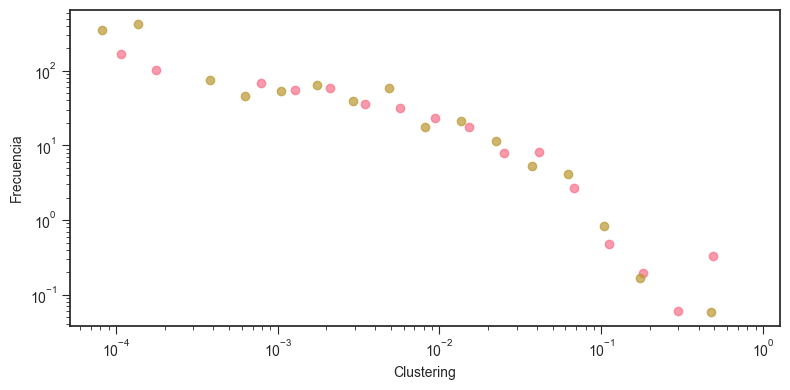

In [199]:
graficar_distribucion('Clustering', log_scale=True, ajuste=False, norm=False)

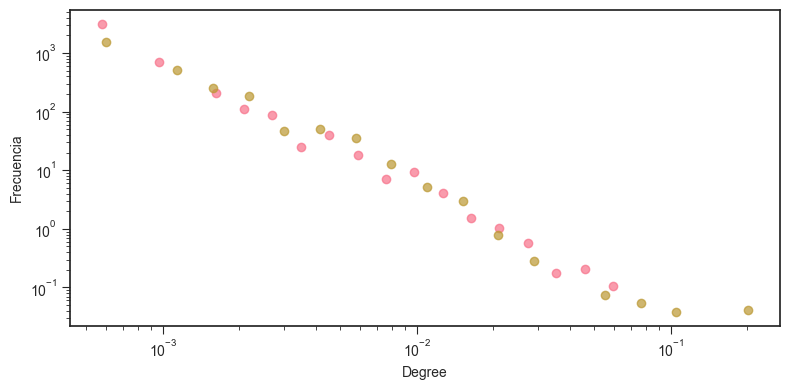

In [191]:
graficar_distribucion('Degree', log_scale=True, ajuste=False, norm=False)

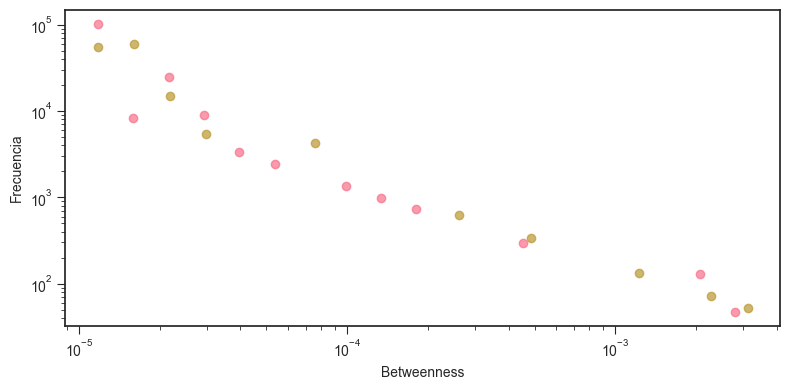

In [192]:
graficar_distribucion('Betweenness', log_scale=True, ajuste=False, norm=False)

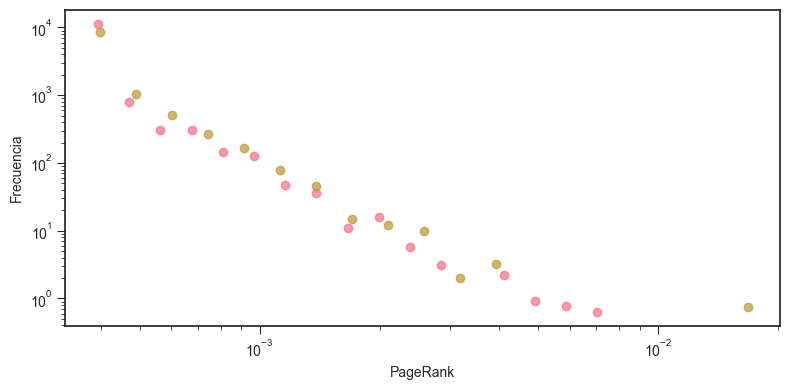

In [193]:
graficar_distribucion('PageRank', log_scale=True, ajuste=False, norm=False)

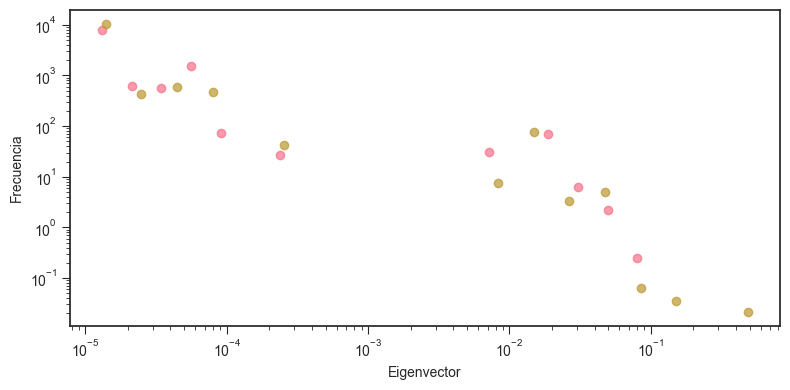

In [194]:
graficar_distribucion('Eigenvector', log_scale=True, ajuste=False, norm=False)

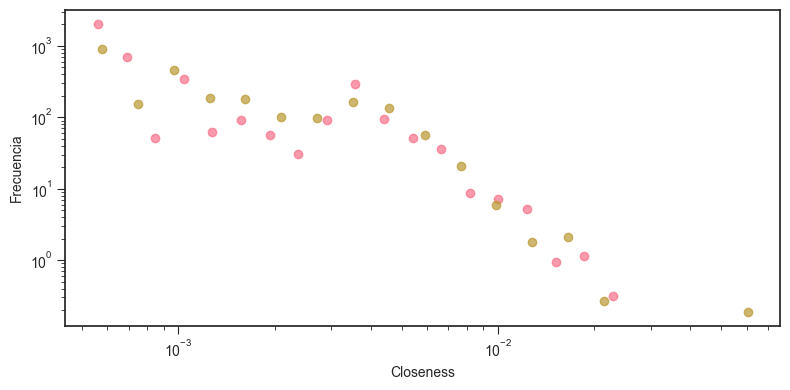

In [195]:
graficar_distribucion('Closeness', log_scale=True, ajuste=False, norm=False)

### Anidamiento aplicado a esto ???

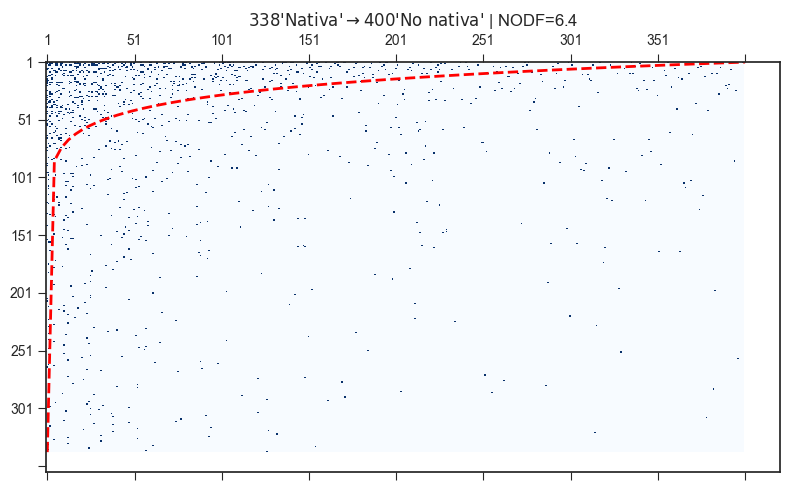

In [234]:
def get_incidence_matrix(subgrafo):
    """Función generalizada para obtener matriz de incidencia para cualquier par de reinos"""
    # Determinar los dos reinos involucrados
    reinos = set()
    for u, v, data in subgrafo.edges(data=True):
        reino_u, reino_v = data['origen'].split("-")
        reinos.update([reino_u, reino_v])
    
    if len(reinos) != 2:
        print(reinos)
        raise ValueError("El subgrafo debe contener exactamente dos reinos diferentes")
    
    reino1, reino2 = sorted(reinos)  # Orden alfabético para consistencia
    
    # Identificar nodos por reino
    grupo1 = set()
    grupo2 = set()
    
    for u, v, data in subgrafo.edges(data=True):
        reino_u, reino_v = data['origen'].split("-")
        
        if reino_u == reino1:
            grupo1.add(u)
        elif reino_u == reino2:
            grupo2.add(u)
            
        if reino_v == reino1:
            grupo1.add(v)
        elif reino_v == reino2:
            grupo2.add(v)
    
    grupo1 = list(grupo1)
    grupo2 = list(grupo2)
    
    # Construir matriz de incidencia
    grupo1_to_idx = {nodo: i for i, nodo in enumerate(grupo1)}
    grupo2_to_idx = {nodo: i for i, nodo in enumerate(grupo2)}
    
    rows = []
    cols = []
    for u, v, data in subgrafo.edges(data=True):
        reino_u, reino_v = data['origen'].split("-")
        
        if reino_u == reino1 and reino_v == reino2:
            rows.append(grupo1_to_idx[u])
            cols.append(grupo2_to_idx[v])
        elif reino_u == reino2 and reino_v == reino1:
            rows.append(grupo1_to_idx[v])
            cols.append(grupo2_to_idx[u])
    
    data = np.ones(len(rows))
    matriz = coo_matrix((data, (rows, cols)), shape=(len(grupo1), len(grupo2))).toarray()
    return matriz, grupo1, grupo2, reino1, reino2

plot_nestedness_for_subred('G_o_no', subredes_G_o) 

In [237]:
plot_nestedness_for_subred('G_o_on', subredes_G_o) 

Error al procesar G_o_on: El subgrafo debe contener exactamente dos reinos diferentes


## 4. Robustez

### Dsitribución de grado se salida (fortaleza de especies)

In [11]:
import pandas as pd
import networkx as nx
import numpy as np

def generar_dataframe_top_nodos(grafo):
    """
    Genera un DataFrame con los nodos ordenados por grado de salida,
    incluyendo información de reino y clasificación (Nativo/No-Nativo),
    adaptado a la estructura específica de tu grafo G.
    
    Args:
        grafo (networkx.DiGraph): Grafo dirigido construido con pares_consolidados
        
    Returns:
        pandas.DataFrame: DataFrame con los nodos y sus metadatos
    """
    # 1. Calcular grados de salida y ordenar nodos
    grados_out = dict(grafo.out_degree())
    nodos_ordenados = sorted(grados_out.items(), key=lambda x: x[1], reverse=True)
    
    # 2. Clasificar nodos según la estructura de tu grafo
    clasificacion = {}
    for u, v, data in grafo.edges(data=True):
        origen = data.get("origen", "")
        
        # Asignar clasificación basada en el atributo "origen" de las aristas
        if origen == "Nativa-Nativa":
            clasificacion[u] = clasificacion[v] = "Nativo"
        elif origen == "Nativa-No nativa":
            clasificacion[u], clasificacion[v] = "Nativo", "No-Nativo"
        elif origen == "No nativa-Nativa":
            clasificacion[u], clasificacion[v] = "No-Nativo", "Nativo"
        elif origen == "No nativa-No nativa":
            clasificacion[u] = clasificacion[v] = "No-Nativo"
    
    # Para nodos aislados o sin clasificación (usar atributo de nodo si existe)
    for nodo in grafo.nodes():
        if nodo not in clasificacion:
            # Buscar en los atributos del nodo (si los hay)
            node_data = grafo.nodes[nodo]
            if "origen" in node_data:
                origen_nodo = node_data["origen"]
                clasificacion[nodo] = origen_nodo.split("-")[0] if "-" in origen_nodo else origen_nodo
            else:
                clasificacion[nodo] = "Desconocido"
    
    # 3. Recolectar datos en un DataFrame
    datos_nodos = []
    for nodo, grado in nodos_ordenados:
        # Obtener metadatos del nodo (si existen)
        node_data = grafo.nodes[nodo]
        
        # Obtener reino(s) - viene del atributo "reino" en las aristas
        for _, _, data in grafo.edges(nodo, data=True):
            if "reino" in data:
                reinos_asociados = data["reino"]
        
        # Formatear información de reinos
        if reinos_asociados:
            reino_info = reinos_asociados.split("-")[0]
        else:
            reino_info = "Desconocido"
            
        datos_nodos.append({
            'Nodo': nodo,
            'Grado Out': grado,
            'Reino(s) asociados': reino_info,
            'Origen': clasificacion.get(nodo, "Desconocido")
        })
    
    return pd.DataFrame(datos_nodos)

# Generar el DataFrame (se almacena en df_top_nodos para usarlo en la siguiente celda)
df_top_nodos = generar_dataframe_top_nodos(G)

In [38]:
import pandas as pd
import networkx as nx
from collections import defaultdict

def generar_dataframe_top_nodos(grafo):
    """
    Genera un DataFrame con los nodos ordenados por grado de salida,
    incluyendo información de reino, clasificación (Nativo/No-Nativo),
    y el tipo de interacción predominante (mutualista/parasítica).
    """
    # 1. Calcular grados de salida y ordenar nodos
    grados_out = dict(grafo.out_degree())
    nodos_ordenados = sorted(grados_out.items(), key=lambda x: x[1], reverse=True)
    
    # 2. Clasificar nodos según origen (Nativo/No-Nativo)
    clasificacion = {}
    for u, v, data in grafo.edges(data=True):
        origen = data.get("origen", "")
        
        if origen == "Nativa-Nativa":
            clasificacion[u] = clasificacion[v] = "Nativo"
        elif origen == "Nativa-No nativa":
            clasificacion[u], clasificacion[v] = "Nativo", "No-Nativo"
        elif origen == "No nativa-Nativa":
            clasificacion[u], clasificacion[v] = "No-Nativo", "Nativo"
        elif origen == "No nativa-No nativa":
            clasificacion[u] = clasificacion[v] = "No-Nativo"
    
    # Para nodos aislados o sin clasificación
    for nodo in grafo.nodes():
        if nodo not in clasificacion:
            node_data = grafo.nodes[nodo]
            if "origen" in node_data:
                origen_nodo = node_data["origen"]
                clasificacion[nodo] = origen_nodo.split("-")[0] if "-" in origen_nodo else origen_nodo
            else:
                clasificacion[nodo] = "Desconocido"
    
    # 3. Contar interacciones mutualistas por nodo
    tipo_interaccion = {}
    for nodo in grafo.nodes():
        grado_total = grafo.degree(nodo)  # Grado total (in + out)
        if grado_total == 0:
            tipo_interaccion[nodo] = "Sin interacciones"
            continue
        
        # Contar interacciones mutualistas (DISPERSION, VISITA FLORAL, MUTUALISMO)
        count_mutualistas = 0
        for _, _, data in grafo.edges(nodo, data=True):
            tipo = data.get("interacciones", "").upper()  # Asume atributo 'tipo' en aristas
            if tipo in {"DISPERSION", "VISITA FLORAL", "MUTUALISMO"}:
                count_mutualistas += 1
        
        # Clasificar según mayoría
        if count_mutualistas > grado_total / 2:
            tipo_interaccion[nodo] = "Mutualista"
        else:
            tipo_interaccion[nodo] = "No mutualista"
    
    # 4. Recolectar datos en un DataFrame
    datos_nodos = []
    for nodo, grado in nodos_ordenados:
        node_data = grafo.nodes[nodo]
        
        # Obtener reino(s) - viene del atributo "reino" en las aristas
        for _, _, data in grafo.edges(nodo, data=True):
            if "reino" in data:
                reinos_asociados = data["reino"]
        
        # Formatear información de reinos
        if reinos_asociados:
            reino_info = reinos_asociados.split("-")[0]
        else:
            reino_info = "Desconocido"
        
        datos_nodos.append({
            'Nodo': nodo,
            'Grado Out': grado,
            #'Grado Total': grafo.degree(nodo),
            'Reino asociados': reino_info,
            'Origen': clasificacion.get(nodo, "Desconocido"),
            'Interacción mayoritaria': tipo_interaccion.get(nodo, "Desconocido")
            #'Interacciones mutualistas': count_mutualistas  # Opcional: incluir conteo crudo
        })
    
    return pd.DataFrame(datos_nodos)

# Generar el DataFrame
df_top_nodos = generar_dataframe_top_nodos(G)

In [39]:
atributos_aristas = set()
for _, _, atributos in G.edges(data=True):
    atributos_aristas.update(atributos.keys())
print("Atributos de aristas:", atributos_aristas)

Atributos de aristas: {'origen', 'reino', 'interacciones'}


In [40]:
def mostrar_top_15_nodos(df):
    """
    Muestra los 15 nodos principales con formato profesional,
    adaptado a la estructura de tu grafo G.
    
    Args:
        df (pandas.DataFrame): DataFrame generado por generar_dataframe_top_nodos
    """
    # Seleccionar top 15 y resetear índice
    top_15 = df.head(25).copy()
    top_15.index = np.arange(1, 26)  # Índice empezando en 1
    
    # Configurar estilo de visualización
    styler = top_15.style.format({
        'Grado Out': '{:,.0f}'
    })
    
    # Aplicar formato condicional
    styler = styler.background_gradient(
        subset=['Grado Out'], 
        cmap='YlOrRd',
        vmin=top_15['Grado Out'].min(),
        vmax=top_15['Grado Out'].max()
    )
    
    # Resaltar clasificaciones
    def color_clasificacion(val):
        color_map = {
            'Nativo': 'lightgreen',
            'No-Nativo': 'lightcoral',
            'Nativo (aislado)': 'palegreen',
            'No-Nativo (aislado)': 'mistyrose',
            'Desconocido': 'lightgray'
        }
        return f'background-color: {color_map.get(val, "white")}'
    
    styler = styler.map(color_clasificacion, subset=['Origen'])
    
    # Ajustar ancho de columnas
    styler = styler.set_properties(**{
        'text-align': 'left',
        'white-space': 'pre-wrap'  # Para reinos con múltiples valores
    })
    
    # Mostrar con título
    display(styler.set_caption(
        "Top 25 nodos por grado de salida - Adaptado a estructura de G"
    ))
    
    return top_15

# Mostrar el top 15 (usando el DataFrame generado en la celda anterior)
top_15_nodos = mostrar_top_15_nodos(df_top_nodos)

,Nodo,Grado Out,Reino asociados,Origen,Interacción mayoritaria
1,Apis mellifera,463,Animalia,No-Nativo,Mutualista
2,Myzus persicae,341,Animalia,No-Nativo,No mutualista
3,Macrosiphum euphorbiae,210,Animalia,No-Nativo,No mutualista
4,Bombus pauloensis,139,Animalia,Nativo,Mutualista
5,Neomyzus circumflexus,129,Animalia,No-Nativo,No mutualista
6,Colibri coruscans,117,Animalia,Nativo,Mutualista
7,Bombus hortulanus,111,Animalia,Nativo,Mutualista
8,Thygater aethiops,102,Animalia,Nativo,Mutualista
9,Eristalis tenax,98,Animalia,No-Nativo,Mutualista
10,Tapirus pinchaque,87,Animalia,Nativo,No mutualista


In [5]:
df_ordenado.to_excel("ordenado.xlsx", index=False)

In [6]:
df_ordenado1 = pd.read_excel("ordenado.xlsx")  # Ajusta el nombre de la hoja

In [ ]:
df_aleatorio.to_excel("aleatorio.xlsx", index=False)

In [60]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

def calcular_nestedness(grafo):
    """Implementación alternativa de nestedness sin biMAT"""
    try:
        # Convertir a matriz de adyacencia
        mat = nx.to_numpy_array(grafo)
        if mat.size == 0:
            return np.nan

        # Ordenar filas y columnas por grado decreciente
        row_order = np.argsort(-mat.sum(axis=1))
        col_order = np.argsort(-mat.sum(axis=0))
        mat = mat[row_order][:, col_order]
            
        # Calcular temperatura de nestedness (método de Atmar & Patterson)
        B = mat.sum()  # Número total de links
        N = mat.shape[0] * mat.shape[1]  # Tamaño de la matriz
        if B == 0:
            return np.nan
            
        # Calcular desviación de la triangularidad perfecta
        filled = np.triu(mat, k=1).sum()
        return filled / B  # Métrica simplificada de nestedness
    except:
        return 0.0

def calcular_NODF(grafo):
    mat = nx.to_numpy_array(grafo)
    mat = (mat > 0).astype(int)  # Asegurar que sea binaria
    if mat.size == 0: return np.nan
    
    # Ordenar filas y columnas por grado decreciente
    row_order = np.argsort(-mat.sum(axis=1))
    col_order = np.argsort(-mat.sum(axis=0))
    mat = mat[row_order][:, col_order]
    
    # Cálculo de NODF (versión simplificada)
    n_rows, n_cols = mat.shape
    row_nodf = col_nodf = 0
    valid_pairs = 0
    
    # Para filas
    for i in range(n_rows):
        for j in range(i+1, n_rows):
            ki = mat[i].sum()
            kj = mat[j].sum()
            if ki > 0 and kj > 0 and ki != kj:
                Oij = (mat[i] & mat[j]).sum()
                min_k = min(ki, kj)
                row_nodf += Oij/min_k if ki > kj else 0
                valid_pairs += 1
    
    # Cálculo similar para columnas...
    
    return 100*row_nodf/valid_pairs if valid_pairs > 0 else 0.0

def calcular_robustness_aproximada(grafo):
    """Versión aproximada más eficiente de robustness"""
    try:
        # Métrica proxy 1: Coeficiente de clustering promedio
        clust = nx.average_clustering(grafo.to_undirected())
        
        # Métrica proxy 2: Grado promedio normalizado
        avg_degree = np.mean([d for _, d in grafo.degree()]) / (len(grafo.nodes())-1)
        
        # Métrica proxy 3: Componente gigante relativa
        giant = len(max(nx.connected_components(grafo.to_undirected()), key=len))/len(grafo.nodes())
        
        # Combinación ponderada (ajustar pesos según necesidad)
        return 0.4*clust + 0.3*avg_degree + 0.3*giant
    except:
        return 0.0

def calcular_metricas(grafo):
    """Calcula las 4 métricas de red para un grafo (versión alternativa)"""
    resultados = {}
    
    # 1. Connectance (Conectividad)
    resultados['Connectance'] = nx.density(grafo)
    
    # 2. Modularity (Modularidad)
    try:
        grafo.remove_nodes_from(list(nx.isolates(grafo.to_undirected())))
        comunidades = community.greedy_modularity_communities(grafo)
        resultados['Modularity'] = community.modularity(grafo.to_undirected(), comunidades)
    except Exception as e:
        print(f"\n[Error] No se pudo calcular la modularidad. Razón: {str(e)}")
        resultados['Modularity'] = np.nan
    
    # 3. Nestedness (Anidamiento) - Versión alternativa
    resultados['Nestedness'] = calcular_nestedness(grafo)
    
    # 4. Robustness OPTIMIZADO - O(n^2) en lugar de O(n^4)
    resultados['Robustness'] = calcular_robustness_aproximada(grafo)
    
    return resultados
    

def analisis_remocion_progresiva(grafo, pasos_ordenados=200, pasos_aleatorios=30, repeticiones_aleatorias=40):
    """
    Realiza análisis de remoción progresiva de nodos por grado out y remociones aleatorias
    
    Args:
        grafo: Grafo networkx a analizar
        pasos_ordenados: Número de pasos para remoción ordenada (default 100)
        pasos_aleatorios: Número de pasos para remoción aleatoria (default 100)
        repeticiones_aleatorias: Número de repeticiones para remoción aleatoria (default 10)
        
    Returns:
        df_ordenado: DataFrame con resultados de remoción por grado out
        df_aleatorio: DataFrame con resultados promediados de remociones aleatorias
    """
    # --- Remoción ordenada por grado out ---
    total_nodos = len(grafo.nodes())
    nodos_por_paso_ordenado = max(1, total_nodos // pasos_ordenados)
    nodos_por_paso_aleatorio = max(1, total_nodos // pasos_aleatorios)
    
    # Preparar nodos ordenados por grado out
    nodos_ordenados = sorted(grafo.out_degree(), key=lambda x: x[1], reverse=True)
    nodos_ordenados = [nodo[0] for nodo in nodos_ordenados]
    
    # Realizar remoción ordenada
    resultados_ordenados = []
    g_ordenado = grafo.copy()
    
    with tqdm(total=pasos_ordenados, desc="Remoción ordenada") as pbar:
        for paso in range(pasos_ordenados):
            # Calcular métricas antes de remover
            metricas = calcular_metricas(g_ordenado)
            metricas['Nodos_restantes'] = len(g_ordenado.nodes()) / total_nodos
            resultados_ordenados.append(metricas)
            
            # Remover el porcentaje correspondiente de nodos
            inicio = paso * nodos_por_paso_ordenado
            fin = min((paso + 1) * nodos_por_paso_ordenado, total_nodos)
            nodos_a_remover = nodos_ordenados[inicio:fin]
            g_ordenado.remove_nodes_from(nodos_a_remover)
            
            pbar.update(1)
    
    df_ordenado = pd.DataFrame(resultados_ordenados)
    
    # --- Remoción aleatoria (con paralelización) ---
    def ejecutar_remocion_aleatoria(iteracion):
        """Función que realiza una remoción aleatoria completa"""
        g_aleatorio = grafo.copy()
        nodos = list(g_aleatorio.nodes())
        np.random.shuffle(nodos)
        resultados = []
        
        for paso in range(pasos_aleatorios):
            # Calcular métricas antes de remover
            metricas = calcular_metricas(g_aleatorio)
            metricas['Nodos_restantes'] = len(g_aleatorio.nodes()) / total_nodos
            resultados.append(metricas)
            
            # Remover el porcentaje correspondiente de nodos
            inicio = paso * nodos_por_paso_aleatorio
            fin = min((paso + 1) * nodos_por_paso_aleatorio, total_nodos)
            nodos_a_remover = nodos[inicio:fin]
            g_aleatorio.remove_nodes_from(nodos_a_remover)
        
        return pd.DataFrame(resultados)
    
    # Configurar paralelización
    max_threads = min(12, repeticiones_aleatorias)
    dfs_aleatorios = []
    
    print(f"\nIniciando {repeticiones_aleatorias} remociones aleatorias (usando {max_threads} threads)...")
    
    with ThreadPoolExecutor(max_workers=max_threads) as executor:
        futures = [executor.submit(ejecutar_remocion_aleatoria, i) 
                  for i in range(repeticiones_aleatorias)]
        
        # Barra de progreso mejorada
        with tqdm(total=repeticiones_aleatorias, desc="Remociones aleatorias") as pbar:
            for future in as_completed(futures):
                dfs_aleatorios.append(future.result())
                pbar.update(1)
    
    # Procesar resultados aleatorios
    if dfs_aleatorios:
        df_aleatorio_completo = pd.concat(dfs_aleatorios)
        df_aleatorio = df_aleatorio_completo.groupby('Nodos_restantes').agg(['mean', 'std'])
        df_aleatorio.columns = ['_'.join(col).strip() for col in df_aleatorio.columns.values]
        df_aleatorio.reset_index(inplace=True)
    else:
        df_aleatorio = pd.DataFrame()
    
    return df_ordenado, df_aleatorio


# Ejecutar análisis
df_ordenado, df_aleatorio = analisis_remocion_progresiva(G)

Remoción ordenada: 100%|█████████████████████████████████████████████████████████████| 200/200 [01:06<00:00,  3.02it/s]



[Error] No se pudo calcular la modularidad. Razón: division by zero

[Error] No se pudo calcular la modularidad. Razón: division by zero

[Error] No se pudo calcular la modularidad. Razón: division by zero

[Error] No se pudo calcular la modularidad. Razón: division by zero

[Error] No se pudo calcular la modularidad. Razón: division by zero

[Error] No se pudo calcular la modularidad. Razón: division by zero

[Error] No se pudo calcular la modularidad. Razón: division by zero

[Error] No se pudo calcular la modularidad. Razón: division by zero

[Error] No se pudo calcular la modularidad. Razón: division by zero

[Error] No se pudo calcular la modularidad. Razón: division by zero

[Error] No se pudo calcular la modularidad. Razón: division by zero

[Error] No se pudo calcular la modularidad. Razón: division by zero

[Error] No se pudo calcular la modularidad. Razón: division by zero

[Error] No se pudo calcular la modularidad. Razón: division by zero

[Error] No se pudo calcular la mo

Remociones aleatorias:  40%|███████████████████████▏                                  | 16/40 [38:48<47:31, 118.82s/it]


[Error] No se pudo calcular la modularidad. Razón: division by zero


Remociones aleatorias: 100%|█████████████████████████████████████████████████████████| 40/40 [1:06:28<00:00, 99.72s/it]


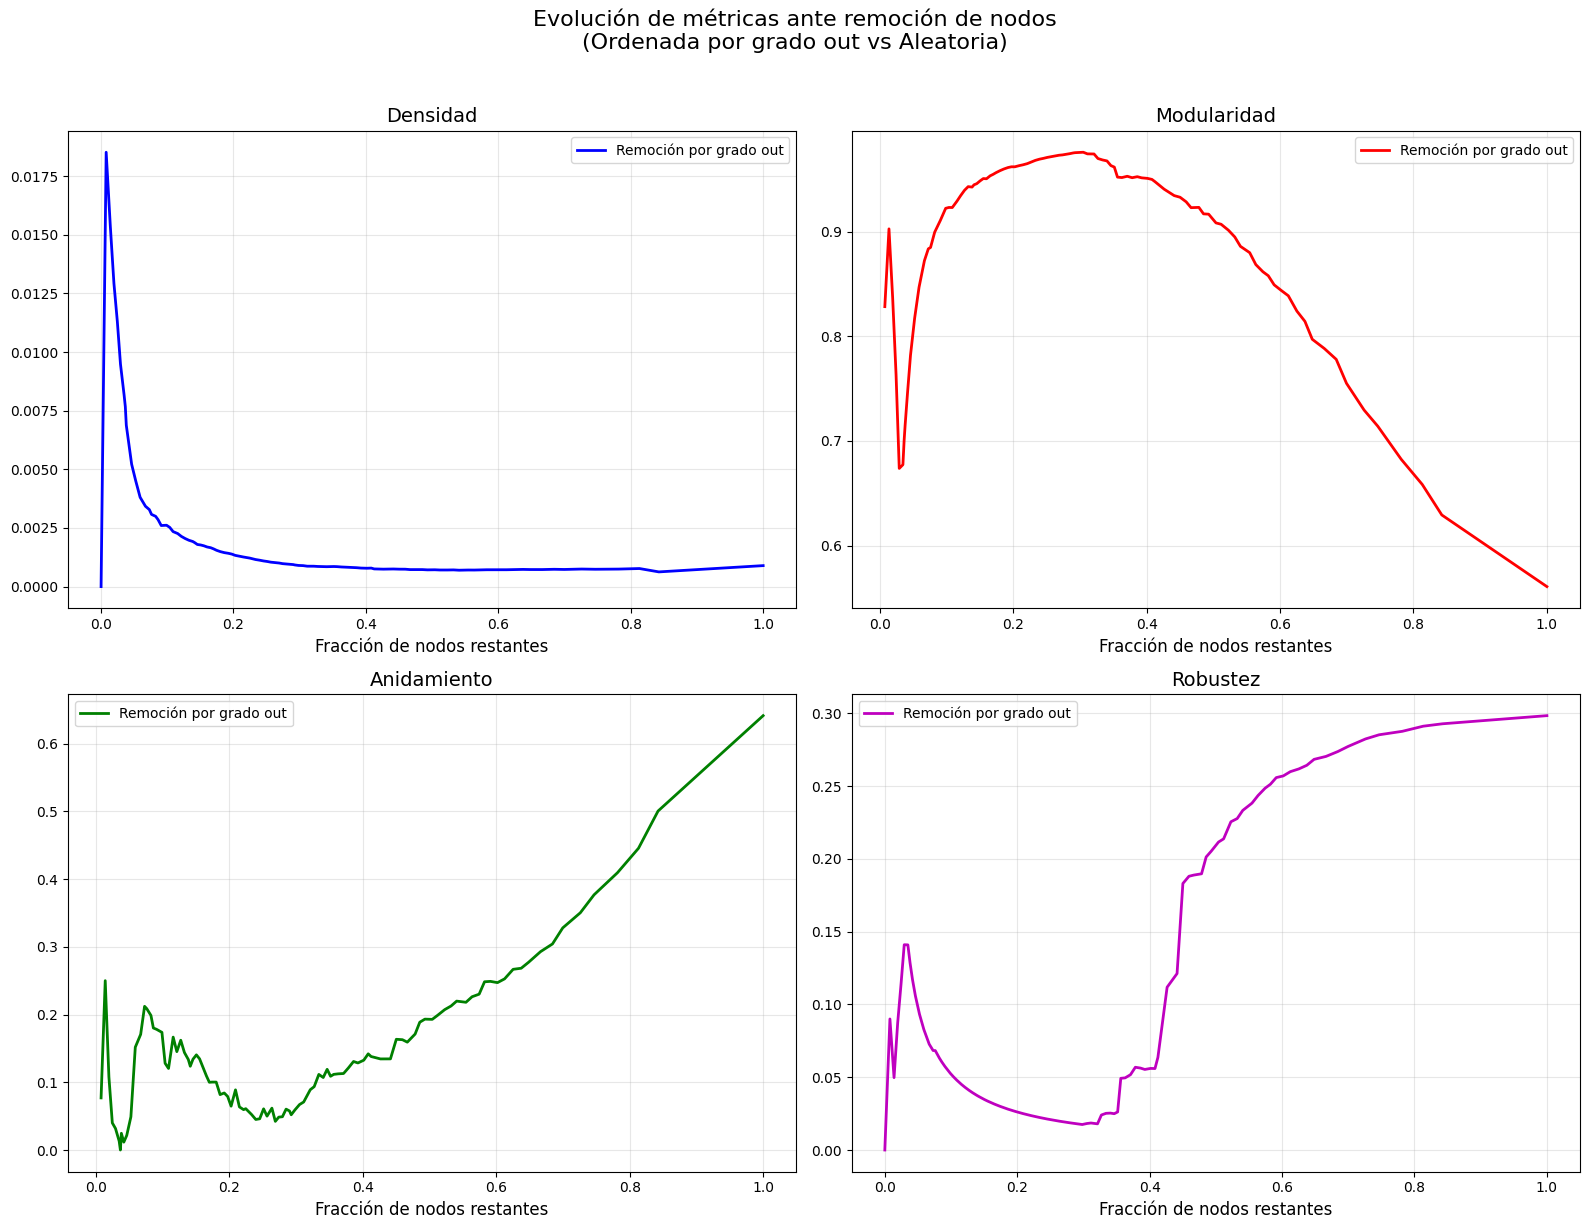

In [59]:
def graficar_resultados_comparativos(df_ordenado, df_aleatorio):
    """Grafica comparativa de remoción ordenada vs aleatoria con barras de error"""
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Evolución de métricas ante remoción de nodos\n(Ordenada por grado out vs Aleatoria)', 
                 fontsize=16, y=1.02)
    
    # Configuración común
    metricas = {
        'Connectance': {'color': 'b', 'label': 'Densidad'},
        'Modularity': {'color': 'r', 'label': 'Modularidad'},
        'Nestedness': {'color': 'g', 'label': 'Anidamiento'}, 
        'Robustness': {'color': 'm', 'label': 'Robustez'}
    }
    
    # Posiciones de los subplots
    posiciones = [(0,0), (0,1), (1,0), (1,1)]
    
    for (i,j), (metrica, config) in zip(posiciones, metricas.items()):
        ax = axs[i,j]
        
        # Curva de remoción ordenada
        ax.plot(df_ordenado['Nodos_restantes'], 
                df_ordenado[metrica], 
                color=config['color'],
                linestyle='-',
                linewidth=2,
                label='Remoción por grado out')
        
        # Curva de remoción aleatoria (con barras de error)
        #ax.errorbar(df_aleatorio['Nodos_restantes'],
         #          df_aleatorio[f'{metrica}_mean'],
          #         yerr=df_aleatorio[f'{metrica}_std'],
           #        color=config['color'],
            #       linestyle='--',
             #      linewidth=1.5,
              #     alpha=0.7,
               #    label='Remoción aleatoria',
                #   capsize=3)
        
        ax.set_title(config['label'], fontsize=14)
        ax.set_xlabel('Fracción de nodos restantes', fontsize=12)
        #ax.set_ylabel(metrica, fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend()
    
    plt.tight_layout()
    plt.savefig('ComparacionRemocion.png', bbox_inches='tight', dpi=300)
    plt.show()

# Ejemplo de uso
if not df_ordenado.empty: #and not df_aleatorio.empty:
    graficar_resultados_comparativos(df_ordenado, df_aleatorio)
else:
    print("Error: Datos incompletos para graficar")

,Connectance,Modularity,Nestedness,Robustness,Nodos_restantes,Nodos_removidos
0,0.000895,0.549478,0.641260,0.298333,1.000000,0
1,0.000787,0.596840,0.591422,0.279749,0.999267,2
2,0.000740,0.609373,0.568467,0.271765,0.998535,4
3,0.000708,0.619329,0.548743,0.264707,0.997802,6
4,0.000680,0.645903,0.533836,0.260006,0.997070,8
...,...,...,...,...,...,...
996,0.000000,NaN,NaN,0.000407,0.270330,1992
997,0.000000,NaN,NaN,0.000408,0.269597,1994
998,0.000000,NaN,NaN,0.000409,0.268864,1996
999,0.000000,NaN,NaN,0.000410,0.268132,1998


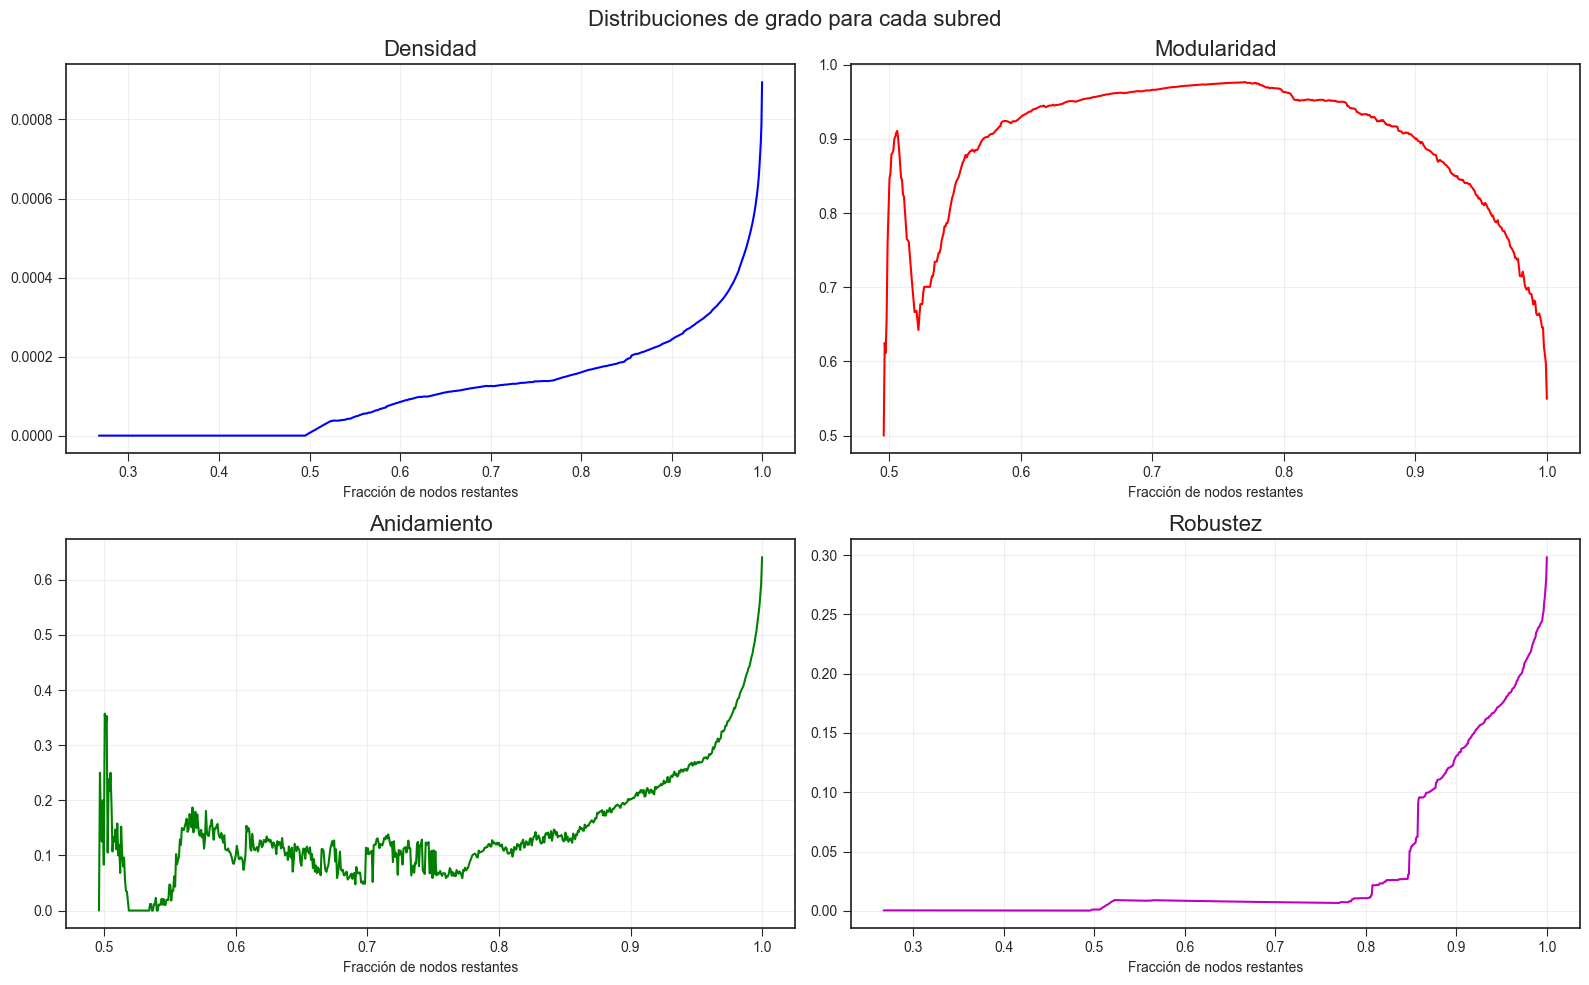

In [225]:
def graficar_resultados(df):
    """Genera los gráficos de evolución de las métricas"""
    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Distribuciones de grado para cada subred', fontsize=16)
    
    # Connectance
    axs[0, 0].plot(df['Nodos_restantes'], df['Connectance'], 'b')
    axs[0, 0].set_title('Densidad', fontsize=16)
    axs[0, 0].set_xlabel('Fracción de nodos restantes')
    axs[0, 0].grid(True, alpha=0.3)
    
    # Modularity
    axs[0, 1].plot(df['Nodos_restantes'], df['Modularity'], 'r')
    axs[0, 1].set_title('Modularidad', fontsize=16)
    axs[0, 1].set_xlabel('Fracción de nodos restantes')
    axs[0, 1].grid(True, alpha=0.3)
    
    # Nestedness
    axs[1, 0].plot(df['Nodos_restantes'], df['Nestedness'], 'g')
    axs[1, 0].set_title('Anidamiento', fontsize=16)
    axs[1, 0].set_xlabel('Fracción de nodos restantes')
    axs[1, 0].grid(True, alpha=0.3)
    
    # Robustness
    axs[1, 1].plot(df['Nodos_restantes'], df['Robustness'], 'm')
    axs[1, 1].set_title('Robustez', fontsize=16)
    axs[1, 1].set_xlabel('Fracción de nodos restantes')
    axs[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('EvolucionMetricas.png')
    plt.show()
    

# Mostrar resultados
if not df_metricas.empty:
    display(df_metricas)
    graficar_resultados(df_metricas)
else:
    print("No se pudieron calcular las métricas. Verifica que el grafo tenga nodos.")